In [24]:
#!/usr/bin/env python3
"""
quick_pull.py – Daily/adhoc pull of hourly energy data from Smappee **grouped only by measurement type**.

Outputs
=======
1. `api_data/hourly_api_data.csv`  – long‑form rows: *Hour, Measurement, Consumption (Wh)*
2. `api_data/aggregated_hourly_measurements.csv` – pivoted table: one column per measurement (kWh, 4‑dp)

Why this version?
-----------------
* **One request per month** (aggregation=2) ⇒ huge speed‑up.
* **Metering configuration → dynamic lookup**. No hard‑coded channel map; whatever measurement names exist in your Smappee account become the pivot columns.
* **No phase column** – the user asked “…just based on the measurement types”.
"""
from __future__ import annotations

import itertools
import logging
import pathlib
import datetime as dt
from typing import Dict, List, Tuple

import requests
import pandas as pd
from dateutil.relativedelta import relativedelta  # pip install python-dateutil
import config  # must expose CLIENT_ID, CLIENT_SECRET, USERNAME, PASSWORD, SMAPPEE_LOCATION_ID

# -----------------------------------------------------------------------------
# CONSTANTS & LOGGING ----------------------------------------------------------
BASE_URL = "https://app1pub.smappee.net/dev/v3"
DATA_DIR = pathlib.Path("final_pipeline/api_data")
DATA_DIR.mkdir(exist_ok=True)
RAW_CSV = DATA_DIR / "hourly_api_data.csv"
AGG_CSV = DATA_DIR / "aggregated_hourly_measurements.csv"

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
LOG = logging.getLogger(__name__)

# -----------------------------------------------------------------------------
# AUTHENTICATION ---------------------------------------------------------------

def get_token(sess: requests.Session) -> str:
    """Return a fresh OAuth2 token."""
    resp = sess.post(
        f"{BASE_URL}/oauth2/token",
        data={
            "grant_type": "password",
            "client_id": config.CLIENT_ID,
            "client_secret": config.CLIENT_SECRET,
            "username": config.USERNAME,
            "password": config.PASSWORD,
        },
        timeout=30,
    )
    resp.raise_for_status()
    return resp.json()["access_token"]

# -----------------------------------------------------------------------------
# METERING CONFIGURATION -------------------------------------------------------

def get_metering_config(sess: requests.Session, token: str, loc_id: int) -> Dict:
    resp = sess.get(
        f"{BASE_URL}/servicelocation/{loc_id}/meteringconfiguration",
        headers={"Authorization": f"Bearer {token}"},
        timeout=30,
    )
    resp.raise_for_status()
    return resp.json()


def build_channel_lookup(metering_config: Dict) -> Dict[int, str]:
    """Return {index_in_active_array: measurement_name}. Ignores phases."""
    lookup: Dict[int, str] = {}
    for measurement in metering_config.get("measurements", []):
        meas_name = measurement.get("name")
        for ch in measurement.get("channels", []):
            c_idx = ch.get("consumptionIndex")
            if c_idx is None:
                continue
            # In API, index may be 1‑based; we convert to 0‑based for Python‑list access.
            arr_idx = c_idx if c_idx == 0 else c_idx - 1
            lookup[arr_idx] = meas_name
    LOG.info("Channel→measurement map: %s", lookup)
    return lookup

# -----------------------------------------------------------------------------
# DATA PULL --------------------------------------------------------------------

def month_chunks(start: dt.datetime, end: dt.datetime):
    """Yield (start, end) tuples covering at most 1 calendar month each."""
    cur = start
    while cur < end:
        nxt = (cur + relativedelta(months=1)).replace(day=1, hour=0, minute=0,
                                                      second=0, microsecond=0)
        yield cur, min(nxt, end)
        cur = nxt


def fetch_month(
    sess: requests.Session,
    loc_id: int,
    token: str,
    start: dt.datetime,
    end: dt.datetime,
    agg: int = 2,
):
    params = {
        "aggregation": agg,
        "from": int(start.timestamp() * 1000),
        "to": int(end.timestamp() * 1000),
    }
    resp = sess.get(
        f"{BASE_URL}/servicelocation/{loc_id}/consumption",
        params=params,
        headers={"Authorization": f"Bearer {token}"},
        timeout=60,
    )
    resp.raise_for_status()
    return resp.json().get("consumptions", [])

# -----------------------------------------------------------------------------
# TRANSFORMATIONS --------------------------------------------------------------

def rows_to_dataframe(rows: List[Dict], ch_lookup: Dict[int, str]) -> pd.DataFrame:
    """Flatten raw rows → tidy DataFrame [Hour, Measurement, Consumption]."""

    out_records: List[Tuple[dt.datetime, str, float]] = []
    for rec in rows:
        ts_ms = rec.get("timestamp")
        if ts_ms is None:
            continue
        hour = dt.datetime.fromtimestamp(ts_ms / 1000, tz=dt.timezone.utc).replace(minute=0, second=0, microsecond=0)
        actives = rec.get("active", [])
        for idx, val in enumerate(actives):
            if val is None:
                continue
            meas = ch_lookup.get(idx)
            if meas is None:
                continue  # skip channels we don't recognise
            out_records.append((hour, meas, val))

    df = pd.DataFrame(out_records, columns=["Hour", "Measurement", "Consumption"])
    return df


def pivot_and_save(df_long: pd.DataFrame):
    """Pivot to wide kWh table and write both CSVs."""

    RAW_CSV.parent.mkdir(exist_ok=True)
    df_long.to_csv(RAW_CSV, index=False)
    LOG.info("Raw hourly file → %s (rows=%d)", RAW_CSV, len(df_long))

    pivot_df = (
        df_long.groupby(["Hour", "Measurement"])["Consumption"].sum()
        .unstack("Measurement")
        .fillna(0)
    )

    pivot_df = (pivot_df / 1000).round(4)  # Wh → kWh
    pivot_df.to_csv(AGG_CSV)
    LOG.info("Aggregated measurement file → %s (hours=%d)", AGG_CSV, len(pivot_df))

# -----------------------------------------------------------------------------
# MAIN ------------------------------------------------------------------------

def main():
    PERIOD_START = dt.datetime(2022, 9, 1, tzinfo=dt.timezone.utc)
    PERIOD_END = dt.datetime.now(dt.timezone.utc)

    with requests.Session() as sess:
        token = get_token(sess)
        LOG.info("Authenticated.")

        met_cfg = get_metering_config(sess, token, config.SMAPPEE_LOCATION_ID)
        ch_lookup = build_channel_lookup(met_cfg)
        if not ch_lookup:
            raise RuntimeError("Channel lookup empty – cannot proceed.")

        rows = list(
            itertools.chain.from_iterable(
                fetch_month(sess, config.SMAPPEE_LOCATION_ID, token, s, e)
                for s, e in month_chunks(PERIOD_START, PERIOD_END)
            )
        )
        LOG.info("Fetched %d JSON rows from API.", len(rows))

    df_long = rows_to_dataframe(rows, ch_lookup)
    pivot_and_save(df_long)


if __name__ == "__main__":
    main()


2025-06-16 15:08:37 | INFO | Authenticated.
2025-06-16 15:08:37 | INFO | Channel→measurement map: {0: 'Grid Organi lbc', 1: 'Grid Organi lbc', 2: 'Chargers', 3: 'Chargers', 4: 'Chargers', 5: 'Solar', 6: 'Solar', 7: 'Solar', 8: 'Chargers achteraan', 9: 'Chargers achteraan', 10: 'Chargers achteraan'}
2025-06-16 15:11:28 | INFO | Fetched 22771 JSON rows from API.
2025-06-16 15:11:30 | INFO | Raw hourly file → final_pipeline\api_data\hourly_api_data.csv (rows=180516)
2025-06-16 15:11:30 | INFO | Aggregated measurement file → final_pipeline\api_data\aggregated_hourly_measurements.csv (hours=22771)


⚠️  Requested columns not found and skipped: ['chargers_total']
✅ Plot saved → final_pipeline\api_data\aggregated_hourly_measurements_plot.png


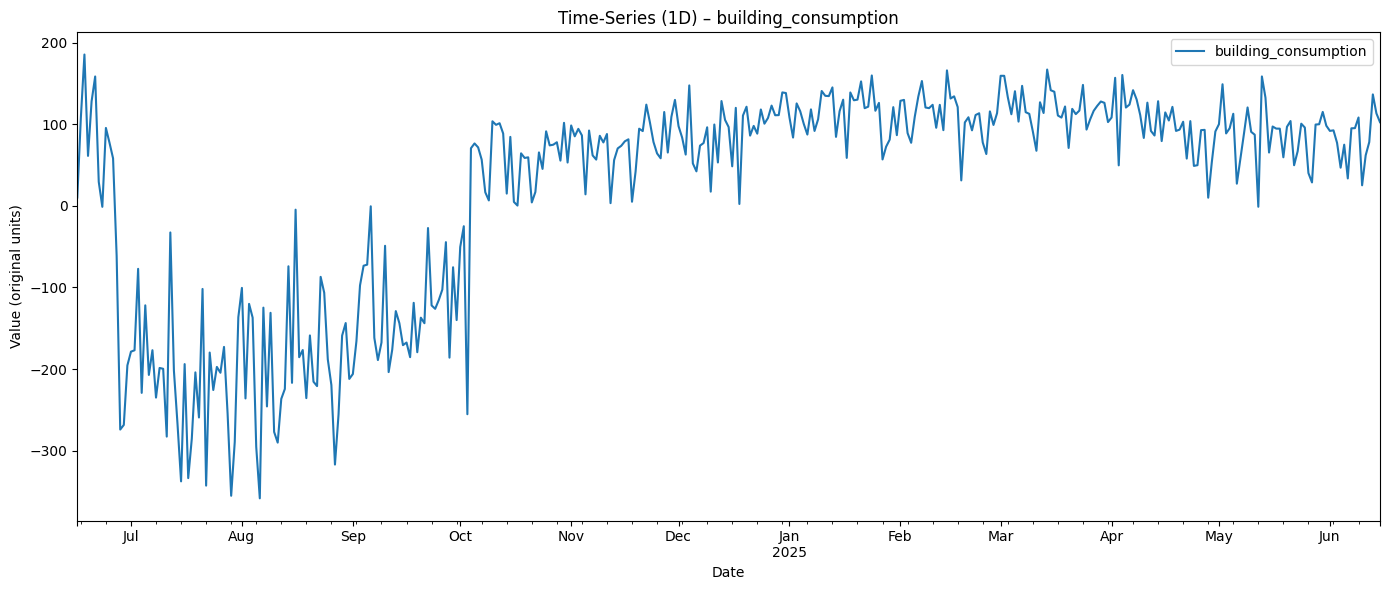

In [27]:
#!/usr/bin/env python3
"""
plot_energy_series.py – one‑click plot for notebooks or scripts
==============================================================

*   **Works out‑of‑the‑box** when you just press ▶️ Run in a Jupyter cell – no
    command‑line arguments needed.
*   Still exposes `save_plot()` so you can reuse it elsewhere.
*   If run as `python plot_energy_series.py` from a shell it behaves the same –
    using the constants you set at the top of the file.

Edit the constants below (`CSV_PATH`, `COLUMNS`, `RESAMPLE`, `OUT_PNG`) to suit
your needs and hit *Run*.  The script shows the plot inline **and** writes a
PNG next to your CSV (unless you set `OUT_PNG = None`).
"""
from __future__ import annotations

import pathlib
from typing import List, Optional

import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# USER CONFIG – tweak these and just run the file
# ---------------------------------------------------------------------------
CSV_PATH: pathlib.Path | str = "final_pipeline/api_data/aggregated_hourly_measurements.csv"
COLUMNS: Optional[List[str]] = ["building_consumption", "chargers_total"]  # None = all numeric
RESAMPLE: Optional[str] = "1D"   # e.g. "1H", "1D", "1W", None or "0" for raw
OUT_PNG: Optional[pathlib.Path | str] = None  # None → auto‑name next to CSV

# ---------------------------------------------------------------------------
# Helper
# ---------------------------------------------------------------------------

def save_plot(
    *,
    csv_path: pathlib.Path | str,
    columns: Optional[List[str]] = None,
    resample: Optional[str] = "1D",
    out: Optional[pathlib.Path | str] = None,
    show: bool = True,
):
    """Create a PNG time‑series plot (and optionally display it)."""

    csv_path = pathlib.Path(csv_path)
    if not csv_path.exists():
        raise FileNotFoundError(f"CSV not found: {csv_path}")

    preview_cols = pd.read_csv(csv_path, nrows=0).columns
    hour_col = "Hour" if "Hour" in preview_cols else "hour"

    df = pd.read_csv(csv_path, parse_dates=[hour_col])
    if hour_col != "hour":
        df.rename(columns={hour_col: "hour"}, inplace=True)
    df.set_index("hour", inplace=True)

    numeric_cols = df.select_dtypes("number").columns.tolist()

    if columns:
        cols_to_plot = [c for c in columns if c in df.columns]
        missing = set(columns) - set(cols_to_plot)
        if missing:
            print(f"⚠️  Requested columns not found and skipped: {sorted(missing)}")
    else:
        cols_to_plot = numeric_cols

    if not cols_to_plot:
        raise ValueError("No numeric columns to plot.")

    plot_df = (
        df[cols_to_plot].resample(resample).sum(numeric_only=True)
        if resample and resample not in {"0", "none", "None"}
        else df[cols_to_plot]
    )

    fig, ax = plt.subplots(figsize=(14, 6))
    plot_df.plot(ax=ax)
    ax.set_title(f"Time‑Series ({resample or 'raw'}) – {', '.join(cols_to_plot)}")
    ax.set_ylabel("Value (original units)")
    ax.set_xlabel("Date")
    fig.tight_layout()

    out_path = pathlib.Path(out) if out else csv_path.with_suffix("") .with_name(csv_path.stem + "_plot.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=150)
    print(f"✅ Plot saved → {out_path}")

    if show:
        plt.show()
    else:
        plt.close(fig)

    return out_path

# ---------------------------------------------------------------------------
# Auto‑run when executed directly (not imported)
# ---------------------------------------------------------------------------

if __name__ == "__main__":
    save_plot(csv_path=CSV_PATH, columns=COLUMNS, resample=RESAMPLE, out=OUT_PNG, show=True)


In [26]:
#!/usr/bin/env python3
"""
aggregate_last_year.py – Trim + adjust rear chargers + merge + derive building load + plot
=========================================================================================

Workflow
--------
1. Read **final_pipeline/api_data/aggregated_hourly_measurements.csv**.
2. Keep the **last 365 days**, **ending at 00:00 this morning** (so today’s partial data is excluded).
3. **Scale “Chargers achteraan” by ×6** *only* for data **before 2024‑10‑04**.
4. Sum *Chargers* + adjusted *Chargers achteraan* → single *Chargers* column.
5. **Derive *building_consumption* = Grid – Chargers + Solar** (`Grid Organi lbc` in CSV).
6. Drop the original *Grid* (`Grid Organi lbc`) and *Solar* columns.
7. Overwrite the CSV.
8. Save a time‑series chart to **final_pipeline/api_data/consumption_last_year.png**.

Run:
```bash
python quick_pull.py          # pulls & pivots
python aggregate_last_year.py # trim, adjust, merge, derive, plot
```
"""
from __future__ import annotations

import pathlib
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# Paths / constants
# -----------------------------------------------------------------------------
DATA_DIR = pathlib.Path("final_pipeline/api_data")
SRC_CSV = DATA_DIR / "aggregated_hourly_measurements.csv"
PLOT_PNG = DATA_DIR / "consumption_last_year.png"

YEARS_BACK = 1
CHARGER_COLS = ["Chargers", "Chargers achteraan"]
CHARGER_OUT_COL = "Chargers"
ADJUST_CUTOFF = pd.Timestamp("2024-10-04", tz="UTC")  # scale until this date (exclusive)
REAR_MULTIPLIER = 6

GRID_COL = "Grid Organi lbc"
SOLAR_COL = "Solar"
BUILDING_CONS_COL = "building_consumption"

# -----------------------------------------------------------------------------

def main() -> None:
    """Entry point."""

    # 1️⃣  Load source CSV ------------------------------------------------------
    if not SRC_CSV.exists():
        raise FileNotFoundError(f"CSV not found: {SRC_CSV}. Run quick_pull.py first.")

    df = pd.read_csv(SRC_CSV, parse_dates=["Hour"])

    # 2️⃣  Slice to last 365 days, stopping at 00:00 today --------------------
    today_midnight = pd.Timestamp.now(tz="UTC").normalize()  # 00:00 today UTC
    start_window = today_midnight - pd.DateOffset(years=YEARS_BACK)

    df = df[(df["Hour"] >= start_window) & (df["Hour"] < today_midnight)].copy()

    # 3️⃣  Adjust rear‑end chargers -------------------------------------------
    missing_chargers = [c for c in CHARGER_COLS if c not in df.columns]
    if missing_chargers:
        raise ValueError(f"Expected charger columns not found: {missing_chargers}")

    mask_before_cutoff = df["Hour"] < ADJUST_CUTOFF
    df.loc[mask_before_cutoff, "Chargers achteraan"] *= REAR_MULTIPLIER

    # 4️⃣  Merge chargers into single column ----------------------------------
    df[CHARGER_OUT_COL] = df[CHARGER_COLS].sum(axis=1)
    # Drop all but first Chargers column (keeps total chargers)
    df.drop(columns=CHARGER_COLS[1:], inplace=True)

    # 5️⃣  Derive building consumption ----------------------------------------
    for col in (GRID_COL, SOLAR_COL):
        if col not in df.columns:
            raise ValueError(f"Expected column not found: '{col}'")

    df[BUILDING_CONS_COL] = df[GRID_COL] - df[CHARGER_OUT_COL] + df[SOLAR_COL]

    # 6️⃣  Remove Grid & Solar columns ----------------------------------------
    df.drop(columns=[GRID_COL, SOLAR_COL], inplace=True)

    # 7️⃣  Re‑order columns ----------------------------------------------------
    ordered_cols = ["Hour", BUILDING_CONS_COL, CHARGER_OUT_COL] + [
        c for c in df.columns if c not in {"Hour", BUILDING_CONS_COL, CHARGER_OUT_COL}
    ]
    df = df[ordered_cols]

    # 8️⃣  Save updated CSV ----------------------------------------------------
    df.to_csv(SRC_CSV, index=False)
    print(f"✅ CSV updated – rows: {len(df)} → {SRC_CSV}")

    # 9️⃣  Plot ---------------------------------------------------------------
    plt.figure(figsize=(14, 6))
    df.set_index("Hour").plot(ax=plt.gca())
    plt.title("Energy Consumption – Last 12 Months (kWh)")
    plt.ylabel("kWh per hour")
    plt.xlabel("Time (UTC)")
    plt.tight_layout()
    PLOT_PNG.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(PLOT_PNG, dpi=150)
    plt.close()
    print(f"📈 Plot saved → {PLOT_PNG}")


if __name__ == "__main__":
    main()


✅ CSV updated – rows: 8760 → final_pipeline\api_data\aggregated_hourly_measurements.csv
📈 Plot saved → final_pipeline\api_data\consumption_last_year.png


In [ ]:
#!/usr/bin/env python3
"""
forecast_switch.py – One script → two forecasts
==============================================

Reads **final_pipeline/api_data/aggregated_hourly_measurements.csv** (the file
produced by `aggregate_last_year.py`).  Depending on `MODE`, it trains and
back‑tests either:

* **Building** forecast  → target `building_consumption`  (LightGBM)
* **Charging** forecast  → target `Chargers`              (XGBoost)

Both modes perform a **30‑day rolling walk‑forward** evaluation and write a
simple Actual vs Predicted plot to `figs/<mode>_backtest.png`.

Usage
-----
```bash
MODE=building  python forecast_switch.py   # building load
MODE=charging  python forecast_switch.py   # charging load
# or edit MODE in the file below
```
"""
from __future__ import annotations

import os
import numpy as np
import pandas as pd
import holidays
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Third‑party models ----------------------------------------------------------
try:
    import lightgbm as lgb
except ModuleNotFoundError:
    lgb = None
try:
    import xgboost as xgb
except ModuleNotFoundError:
    xgb = None

# ═════════════════════ USER SWITCH ═════════════════════
MODE = os.getenv("MODE", "charging").lower()  # "building" | "charging"
# ══════════════════════════════════════════════════════

# ↳ Paths --------------------------------------------------------------------
ROOT       = Path("final_pipeline/api_data")
DATA_CSV   = ROOT / "aggregated_hourly_measurements.csv"
CALENDAR   = Path("./hourly_predictions/layout1_full_calendar_2023-2025.csv")  # only for charging
PLOTS_DIR  = Path("figs"); PLOTS_DIR.mkdir(exist_ok=True)

# ↳ Parameters ---------------------------------------------------------------
BACKTEST_DAYS   = 30
RANDOM_STATE    = 42
TOTAL_HEADCOUNT = 105    # charging features
SESSION_KWH     = 9.5

# ↳ Belgian public holidays --------------------------------------------------
be_holidays = lambda yrs: holidays.BE(years=yrs)

# ↳ Terugkomdagen (in‑office days) ------------------------------------------
TKD = pd.to_datetime([
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]).normalize()

# ---------------------------------------------------------------------------
# Helper – metrics + plot
# ---------------------------------------------------------------------------

def evaluate_and_plot(df: pd.DataFrame, title: str, stub: str) -> None:
    mae   = mean_absolute_error(df['y'], df['yhat'])
    rmse  = np.sqrt(mean_squared_error(df['y'], df['yhat']))
    r2    = r2_score(df['y'], df['yhat'])
    mape  = (np.abs(df['y']-df['yhat'])/(df['y']+1e-10)).mean()*100
    smape = (2*np.abs(df['y']-df['yhat'])/(np.abs(df['y'])+np.abs(df['yhat'])+1e-10)).mean()*100

    print("\n════════════════ 30‑day back‑test ════════════════")
    print(f"MAE   : {mae:.2f} kWh  |  RMSE : {rmse:.2f} kWh  |  R² : {r2:.3f}")
    print(f"MAPE  : {mape:.2f}%   |  sMAPE: {smape:.2f}%")

    plt.figure(figsize=(12,5))
    plt.plot(df['ds'], df['y'],    label='Actual',    alpha=.6)
    plt.plot(df['ds'], df['yhat'], label='Predicted', alpha=.8)
    plt.title(title); plt.ylabel('kWh'); plt.tight_layout()
    out_png = PLOTS_DIR / f"{stub}_backtest.png"
    plt.savefig(out_png, dpi=150)
    plt.close()
    print(f"📈 Plot → {out_png}")

# ---------------------------------------------------------------------------
# BUILDING FORECAST  (LightGBM)
# ---------------------------------------------------------------------------

def forecast_building() -> None:
    if lgb is None:
        raise ImportError("lightgbm is not installed. run: pip install lightgbm")
    if not DATA_CSV.exists():
        raise FileNotFoundError(f"{DATA_CSV} not found – run aggregate_last_year.py")

    df = (pd.read_csv(DATA_CSV, parse_dates=['Hour'])
            .rename(columns={'Hour':'ds','building_consumption':'y'})
            .sort_values('ds').reset_index(drop=True))

    hols = be_holidays(df['ds'].dt.year.unique())
    df['weekday']    = df['ds'].dt.weekday
    df['hour']       = df['ds'].dt.hour
    df['is_weekend'] = (df['weekday']>=5).astype(int)
    df['is_work_hr'] = df['hour'].between(8,18).astype(int)
    df['is_holiday'] = df['ds'].dt.normalize().isin(hols).astype(int)
    df['is_tkd']     = df['ds'].dt.normalize().isin(TKD).astype(int)

    df['lag_168'] = df['y'].shift(168).fillna(df['y'].mean())
    seasonal = (df.groupby(['weekday','hour'])['y'].mean()
                  .rename('season_mean').reset_index())
    df = df.merge(seasonal,on=['weekday','hour'],how='left')

    FEATURES = ['is_weekend','is_work_hr','is_holiday','is_tkd','lag_168','season_mean']

    predictions = []
    start_eval = df['ds'].max() - pd.Timedelta(days=BACKTEST_DAYS)
    for day in pd.date_range(start_eval.normalize(), df['ds'].max().normalize(), freq='D'):
        train = df[df['ds'] < day]
        model = lgb.LGBMRegressor(n_estimators=600, learning_rate=.05, random_state=RANDOM_STATE)
        model.fit(train[FEATURES], train['y'])

        day_slice = df[(df['ds']>=day)&(df['ds']<day+pd.Timedelta(days=1))].copy()
        day_slice['yhat'] = model.predict(day_slice[FEATURES])
        predictions.append(day_slice[['ds','y','yhat']])

    res = pd.concat(predictions)
    evaluate_and_plot(res, 'Charging load – 30‑day back‑test', 'charging')

    predictions.append(day_slice[['ds','y','yhat']])

    res = pd.concat(predictions)
    evaluate_and_plot(res, 'Building load – 30‑day back‑test', 'building')

# ---------------------------------------------------------------------------
# CHARGING FORECAST (XGBoost)
# ---------------------------------------------------------------------------

def forecast_charging() -> None:
    if xgb is None:
        raise ImportError("xgboost is not installed. run: pip install xgboost")
    if not DATA_CSV.exists():
        raise FileNotFoundError(f"{DATA_CSV} not found – run aggregate_last_year.py")
    if not CALENDAR.exists():
        raise FileNotFoundError(f"Workforce calendar missing: {CALENDAR}")

    df = (pd.read_csv(DATA_CSV, parse_dates=['Hour'])
            .rename(columns={'Hour':'ds','Chargers':'y'})
            .sort_values('ds').reset_index(drop=True))

    # Workforce calendar
    cal = (pd.read_csv(CALENDAR, parse_dates=['Datum'])
             .rename(columns={'Datum':'cal_date','Totaal_Vakantiedagen':'vac','Totaal_Thuiswerkdagen':'home'}))
    cal['cal_date'] = cal['cal_date'].dt.date
    df['cal_date']  = df['ds'].dt.date
    df = df.merge(cal, on='cal_date', how='left').fillna({'vac':0,'home':0})

    hols = be_holidays(df['ds'].dt.year.unique())
    df['weekday']    = df['ds'].dt.weekday
    df['hour']       = df['ds'].dt.hour
    df['is_weekend'] = (df['weekday']>=5).astype(int)
    df['is_work_hr'] = df['hour'].between(8,18).astype(int)
    df['is_holiday'] = df['ds'].dt.normalize().isin(hols).astype(int)
    df['is_tkd']     = df['ds'].dt.normalize().isin(TKD).astype(int)
    df['is_fri']     = (df['weekday']==4).astype(int)
    df['is_pre_hol'] = ((df['ds'].dt.normalize()+pd.Timedelta(days=1)).isin(hols)).astype(int)

    df['at_office'] = np.where(
        (df['weekday']<5)&(df['is_holiday']==0)&(df['is_work_hr']==1),
        (TOTAL_HEADCOUNT - df['vac'] - df['home']).clip(lower=0), 0)

    df['lag_168'] = df['y'].shift(168).fillna(df['y'].mean())
    seasonal = (df.groupby(['weekday','hour'])['y'].mean()
                  .rename('season_mean').reset_index())
    df = df.merge(seasonal,on=['weekday','hour'],how='left')
    df['avg_cars_wd'] = df.groupby('weekday')['y'].transform('mean') / SESSION_KWH

    FEATURES = [
        'is_work_hr','is_weekend','is_holiday','is_tkd','is_fri','is_pre_hol',
        'at_office','lag_168','season_mean','avg_cars_wd'
    ]

    predictions = []
    start_eval = df['ds'].max() - pd.Timedelta(days=BACKTEST_DAYS)
    for day in pd.date_range(start_eval.normalize(), df['ds'].max().normalize(), freq='D'):
        train = df[df['ds'] < day]
        model = xgb.XGBRegressor(n_estimators=800, learning_rate=.05, max_depth=6,
                                 objective='reg:squarederror', random_state=RANDOM_STATE, verbosity=0)
        model.fit(train[FEATURES], train['y'])

        slice_ = df[(df['ds']>=day)&(df['ds']<day+pd.Timedelta(days=1))].copy()
        slice_['yhat'] = model.predict(slice_[FEATURES])
        predictions.append(slice_[['ds','y','yhat']])

    res = pd.concat(predictions)
    evaluate_and_plot(res, 'Charging load – 30‑day back‑test', 'charging')

# ---------------------------------------------------------------------------
# Main
# ---------------------------------------------------------------------------
if __name__ == '__main__':
    if MODE == 'building':
        forecast_building()
    elif MODE == 'charging':
        forecast_charging()
    else:
        raise ValueError("MODE must be 'building' or 'charging'")


C:\Users\user\AppData\Local\Temp\ipykernel_22428\3588800562.py:93: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns, UTC] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  _df["is_holiday"]   = _df["ds"].dt.normalize().isin(hols).astype(int)
C:\Users\user\AppData\Local\Temp\ipykernel_22428\3588800562.py:93: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns, UTC] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  _df["is_holiday"]   = _df["ds"].dt.normalize().isin(hols).astype(int)



══ Forecast for 2025-04-21 ══
MAE  : 20.13 kWh  |  RMSE : 1062.22 kWh  |  R² : -555698.963


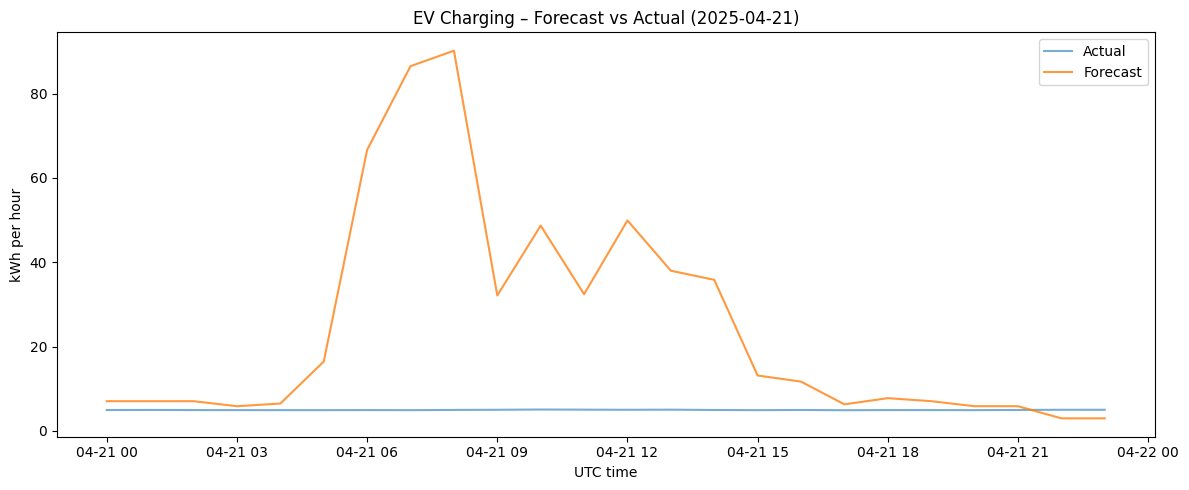

📈 Plot saved → figs\charging_one_day_forecast_2025-04-21.png


In [8]:
#!/usr/bin/env python3
"""
one_day_charging_forecast.py – 24 h forecast with **pkl model** & original feature set
=====================================================================================

* Source data: `final_pipeline/api_data/aggregated_hourly_measurements.csv`
* Trained model: `charging_model.pkl` — trained with **exactly** the feature
  list below (7 variables).
* Choose the forecast date by:
  * editing `FORECAST_DATE` just below, **or**
  * setting the env‑var `FORECAST_DATE=YYYY‑MM‑DD` (overrides the code).
* The script:
  1. Builds the historical feature frame up to the chosen day;
  2. Derives the two *aggregate* features (`avg_hourly_by_weekday`,
     `avg_cars_weekday`) **from the training part only** (as in training code);
  3. Computes a lag‑168 feature;
  4. Feeds the 24 forecast rows to the pre‑trained model;
  5. Prints MAE/RMSE/R² and plots Actual vs Forecast to
     `figs/charging_one_day_forecast_<date>.png`.
"""
from __future__ import annotations

import os
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import holidays
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ───────────────────────────── USER INPUT ─────────────────────────────
FORECAST_DATE = "2025-04-21"   # "2025-05-31" or leave blank for last day
FORECAST_DATE = os.getenv("FORECAST_DATE", FORECAST_DATE)

# ───────────────────────────── PATHS / CONST ──────────────────────────
ROOT      = Path("final_pipeline/api_data")
DATA_CSV  = ROOT / "aggregated_hourly_measurements.csv"
MODEL_PKL = Path("./final_pipeline/charging_model.pkl")
PLOT_DIR  = Path("figs"); PLOT_DIR.mkdir(exist_ok=True)

SESSION_KWH = 9.5  # avg energy per vehicle session (for avg_cars_weekday)

# public holidays helper
be_holidays = lambda yrs: holidays.BE(years=yrs)
TKD = pd.to_datetime([
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]).normalize()

FEATURES = [
    "is_weekend","is_work_hour","avg_hourly_by_weekday",
    "is_holiday","is_terugkomdag","lag_168","avg_cars_weekday",
]

# ───────────────────────────── LOAD DATA & MODEL ─────────────────────
for p in (DATA_CSV, MODEL_PKL):
    if not p.exists():
        raise FileNotFoundError(p)

with open(MODEL_PKL, "rb") as f:
    model = pickle.load(f)

df = (pd.read_csv(DATA_CSV, parse_dates=["Hour"])
        .rename(columns={"Hour":"ds","Chargers":"y"})
        .sort_values("ds").reset_index(drop=True))

# ───────────────────────────── CHOOSE DAY ────────────────────────────
last_day = df["ds"].dt.normalize().max()
forecast_day = pd.Timestamp(FORECAST_DATE).tz_localize("UTC") if FORECAST_DATE else last_day
if forecast_day not in df["ds"].dt.normalize().unique():
    raise ValueError(f"Day {forecast_day.date()} not in dataset")

# Split
train_df    = df[df["ds"].dt.normalize() < forecast_day].copy()
forecast_df = df[df["ds"].dt.normalize() == forecast_day].copy()
if forecast_df.empty:
    raise ValueError("No rows for forecast day")

# ───────────────────────────── FEATURE ENGINEERING ───────────────────
# Static flags
hols = be_holidays(df["ds"].dt.year.unique())

for _df in (train_df, forecast_df):
    _df["weekday"]      = _df["ds"].dt.weekday
    _df["hour"]         = _df["ds"].dt.hour
    _df["is_weekend"]   = (_df["weekday"]>=5).astype(int)
    _df["is_work_hour"] = _df["hour"].between(8,18).astype(int)
    _df["is_holiday"]   = _df["ds"].dt.normalize().isin(hols).astype(int)
    _df["is_terugkomdag"] = _df["ds"].dt.normalize().isin(TKD).astype(int)

# Aggregate mappings derived from TRAIN ONLY
avg_map = (train_df.groupby(["weekday","hour"])["y"].mean()
                     .rename("avg_hourly_by_weekday").reset_index())
forecast_df = forecast_df.merge(avg_map, on=["weekday","hour"], how="left")

lag_series = train_df[["ds","y"]].copy()
lag_series["ds"] += pd.Timedelta(days=7)
lag_series.rename(columns={"y":"lag_168"}, inplace=True)
forecast_df = forecast_df.merge(lag_series, on="ds", how="left")

# Fallback for missing lag_168 ➜ use avg_hourly_by_weekday
forecast_df["lag_168"] = forecast_df["lag_168"].fillna(forecast_df["avg_hourly_by_weekday"])

cars_map = (train_df.groupby("weekday")["y"].mean() / SESSION_KWH
           ).rename("avg_cars_weekday").reset_index()
forecast_df = forecast_df.merge(cars_map, on="weekday", how="left")

# ───────────────────────────── PREDICT ───────────────────────────────
forecast_df["yhat"] = model.predict(forecast_df[FEATURES])

# ───────────────────────────── METRICS & PLOT ────────────────────────
mae  = mean_absolute_error(forecast_df["y"], forecast_df["yhat"])
rmse = mean_squared_error(forecast_df["y"], forecast_df["yhat"])
r2   = r2_score(forecast_df["y"], forecast_df["yhat"])
print("\n══ Forecast for", forecast_day.date(), "══")
print(f"MAE  : {mae:.2f} kWh  |  RMSE : {rmse:.2f} kWh  |  R² : {r2:.3f}")

plt.figure(figsize=(12,5))
plt.plot(forecast_df["ds"], forecast_df["y"],    label="Actual",   alpha=.6)
plt.plot(forecast_df["ds"], forecast_df["yhat"], label="Forecast", alpha=.8)
plt.title(f"EV Charging – Forecast vs Actual ({forecast_day.date()})")
plt.ylabel("kWh per hour"); plt.xlabel("UTC time")
plt.legend(); plt.tight_layout()
plot_path = PLOT_DIR / f"charging_one_day_forecast_{forecast_day.date()}.png"
plt.savefig(plot_path, dpi=150)
plt.show()
plt.close()
print(f"📈 Plot saved → {plot_path}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1231
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 12
[LightGBM] [Info] Start training from score 11.209267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1231
[LightGBM] [Info] Number of data points in the train set: 6984, number of used features: 12
[LightGBM] [Info] Start training from score 11.171286
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

C:\Users\user\AppData\Local\Temp\ipykernel_13964\3926487464.py:107: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r2_h       = bt.groupby("horizon").apply(lambda g: r2_score(g["y"], g["yhat"]))


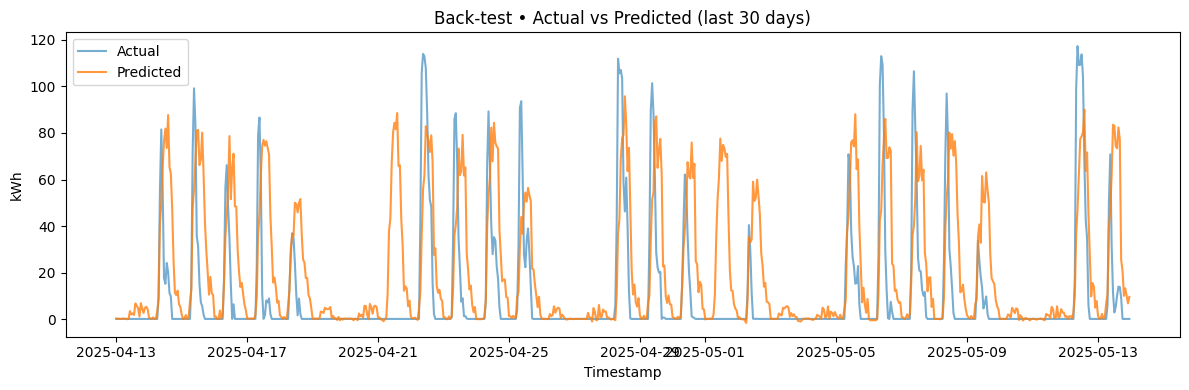

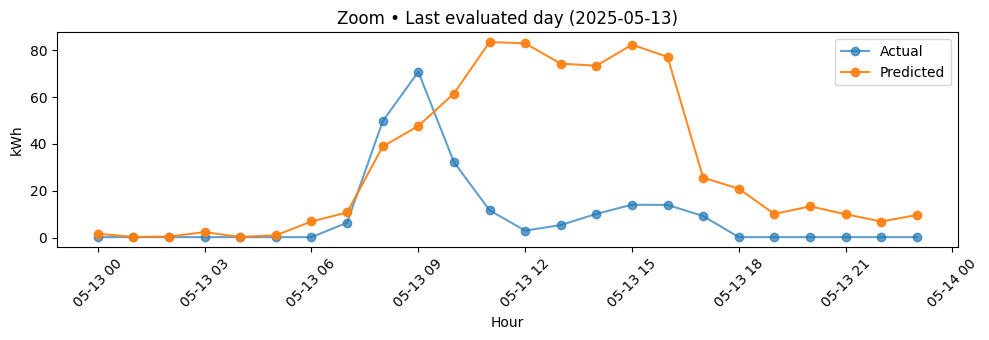

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1231
[LightGBM] [Info] Number of data points in the train set: 7704, number of used features: 12
[LightGBM] [Info] Start training from score 11.128141
✓ Model & artefacts saved → ./final_pipeline/charging_recursive.pkl


In [4]:
# ──────────────────────────────────────────────────────────────
#  Recursive (+1 h) LightGBM forecaster for EV-charging load
#  • Robust holiday / terugkomdag handling (one global date set)
#  • 30-day recursive walk-forward validation + rich metrics
#  • Two plots (30 d timeline, 24 h zoom)
#  • Saves model + artefacts + inference helper
# ──────────────────────────────────────────────────────────────
import os, joblib, numpy as np, pandas as pd, holidays, lightgbm as lgb, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ═════════════════ 1.  LOAD & CALENDAR SETS ══════════════════
df = pd.read_csv("./charging_forecasts/Charging_data_hourly.csv")
df["ds"] = pd.to_datetime(df["Date"])
df = df.sort_values("ds").rename(columns={"Chargers": "y"})

# ----  build one canonical holiday set (datetime.date)  ----
earliest = df["ds"].dt.year.min()
latest   = df["ds"].dt.year.max()
YEARS    = range(earliest - 1, latest + 6)      # buffer: −1 yr … +5 yr
BE_HOLIDAYS = {d for y in YEARS for d in holidays.Belgium(years=y).keys()}

# terugkomdagen (also as date set)
TKD_DATES = {d.date() for d in pd.to_datetime([
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
])}

# vectorised calendar flags --------------------------------------------------
ds_date = df["ds"].dt.date
df["is_holiday"]     = ds_date.isin(BE_HOLIDAYS).astype(int)
df["is_terugkomdag"] = ds_date.isin(TKD_DATES).astype(int)
df["weekday"]        = df["ds"].dt.weekday
df["hour"]           = df["ds"].dt.hour
df["is_weekend"]     = (df["weekday"] >= 5).astype(int)
df["is_work_hour"]   = ((df["hour"] >= 8) & (df["hour"] <= 18)).astype(int)

# lags -----------------------------------------------------------------------
for lag in [1, 2, 3, 168]:
    df[f"lag_{lag}"] = df["y"].shift(lag)
df[["lag_1","lag_2","lag_3","lag_168"]] = df[["lag_1","lag_2","lag_3","lag_168"]]\
    .fillna(df["y"].rolling(24*7, min_periods=1).mean())

# simple averages ------------------------------------------------------------
SESSION_KWH = 9.5
df["avg_hourly_by_weekday"] = df.groupby(["weekday","hour"])["y"].transform("mean")
df["avg_cars_weekday"]      = df.groupby("weekday")["y"].transform("mean") / SESSION_KWH

FEATURES = [
    "is_weekend","is_work_hour","is_holiday","is_terugkomdag",
    "weekday","hour",
    "lag_1","lag_2","lag_3","lag_168",
    "avg_hourly_by_weekday","avg_cars_weekday"
]

# ═════════════════ 2.  30-DAY RECURSIVE BACK-TEST ════════════
start_eval = df["ds"].max() - pd.Timedelta(days=30)
days_iter  = pd.date_range(start_eval.normalize(), df["ds"].max().normalize(), freq="D")

bt_blocks = []

for day in days_iter:
    t0, t1 = pd.Timestamp(day), pd.Timestamp(day) + pd.Timedelta(days=1)
    train  = df[df["ds"] < t0].copy()
    target = df[(df["ds"] >= t0) & (df["ds"] < t1)][["ds","y"]].copy()

    model = lgb.LGBMRegressor(objective="regression", alpha=0.55,
                              n_estimators=800, learning_rate=0.05,
                              random_state=42).fit(train[FEATURES], train["y"])

    hist, preds = train[["ds","y"]].copy(), []

    for _, row in target.iterrows():
        ts = row["ds"]
        feat = {
            "weekday": ts.weekday(), "hour": ts.hour,
            "is_weekend": int(ts.weekday() >= 5),
            "is_work_hour": int(8 <= ts.hour <= 18),
            "is_holiday": int(ts.date() in BE_HOLIDAYS),
            "is_terugkomdag": int(ts.date() in TKD_DATES),
            "avg_hourly_by_weekday": df.loc[
                (df["weekday"]==ts.weekday()) & (df["hour"]==ts.hour),
                "avg_hourly_by_weekday"].iloc[0],
            "avg_cars_weekday": df.loc[
                df["weekday"]==ts.weekday(),"avg_cars_weekday"].iloc[0],
            "lag_1": hist.iloc[-1]["y"],
            "lag_2": hist.iloc[-2]["y"] if len(hist)>=2 else hist.iloc[-1]["y"],
            "lag_3": hist.iloc[-3]["y"] if len(hist)>=3 else hist.iloc[-1]["y"],
            "lag_168": df.loc[df["ds"]==ts-pd.Timedelta(hours=168),"y"].iloc[0]
                       if (ts-pd.Timedelta(hours=168) in df["ds"].values)
                       else hist.iloc[-1]["y"],
        }
        y_hat = model.predict(pd.DataFrame({k:[v] for k,v in feat.items() if k in FEATURES}))[0]
        preds.append({"ds":ts,"y":row["y"],"yhat":y_hat,"horizon":len(preds)})
        hist = pd.concat([hist, pd.DataFrame({"ds":[ts],"y":[y_hat]})], ignore_index=True)

    bt_blocks.append(pd.DataFrame(preds))

bt = pd.concat(bt_blocks).sort_values("ds").reset_index(drop=True)

# ═════════════════ 3.  METRICS ═══════════════════════════════
def mape(a,f): return np.mean(np.abs((a-f)/a))*100
mae, rmse  = mean_absolute_error(bt["y"], bt["yhat"]), np.sqrt(mean_squared_error(bt["y"], bt["yhat"]))
r2, mape_  = r2_score(bt["y"], bt["yhat"]), mape(bt["y"], bt["yhat"])
r2_h       = bt.groupby("horizon").apply(lambda g: r2_score(g["y"], g["yhat"]))
daily      = bt.groupby(bt["ds"].dt.date).agg(y_sum=("y","sum"), yhat_sum=("yhat","sum"))
r2_daily   = r2_score(daily["y_sum"], daily["yhat_sum"])

print("\n╭─ Recursive back-test metrics (last 30 days) ─────────────╮")
print(f" MAE  : {mae:8.2f}")
print(f" RMSE : {rmse:8.2f}")
print(f" R²   : {r2:8.3f}")
print(f" MAPE : {mape_:8.2f} %")
print(f" R² daily-sum: {r2_daily:6.3f}")
print(" R² by horizon (h=0…23):")
print(r2_h.round(3).to_string())
print("╰───────────────────────────────────────────────────────────╯")

# ═════════════════ 4.  PLOTS ═════════════════════════════════
plt.figure(figsize=(12,4))
plt.plot(bt["ds"], bt["y"],    label="Actual",    alpha=0.6)
plt.plot(bt["ds"], bt["yhat"], label="Predicted", alpha=0.8)
plt.title("Back-test • Actual vs Predicted (last 30 days)")
plt.xlabel("Timestamp"); plt.ylabel("kWh"); plt.legend(); plt.tight_layout(); plt.show()

zoom_day = bt["ds"].dt.date.max()
zoom     = bt[bt["ds"].dt.date == zoom_day]
plt.figure(figsize=(10,3.5))
plt.plot(zoom["ds"], zoom["y"],    marker="o", label="Actual",    alpha=0.7)
plt.plot(zoom["ds"], zoom["yhat"], marker="o", label="Predicted", alpha=0.9)
plt.title(f"Zoom • Last evaluated day ({zoom_day})")
plt.xlabel("Hour"); plt.ylabel("kWh"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# ═════════════════ 5.  TRAIN FINAL MODEL & SAVE ══════════════
final_model = lgb.LGBMRegressor(objective="regression", alpha=0.55,
                                n_estimators=800, learning_rate=0.05,
                                random_state=42).fit(df[FEATURES], df["y"])

artefacts = {
    "model": final_model,
    "BE_HOLIDAYS": BE_HOLIDAYS,   # set[date]
    "TKD_DATES": TKD_DATES,       # set[date]
    "weekday_hour_avg": df.groupby(["weekday","hour"])["avg_hourly_by_weekday"].mean(),
    "weekday_car_avg":  df.groupby("weekday")["avg_cars_weekday"].mean(),
}
os.makedirs("./final_pipeline", exist_ok=True)
joblib.dump(artefacts, "./final_pipeline/charging_recursive.pkl")
print("✓ Model & artefacts saved → ./final_pipeline/charging_recursive.pkl")

# ═════════════════ 6.  INFERENCE HELPER ═════════════════════
def forecast_next_24h(latest_hist: pd.DataFrame,
                      artefact_path: str = "./final_pipeline/charging_recursive.pkl") -> pd.DataFrame:
    """
    latest_hist  : DataFrame with ≥168 h of *actual* history (cols ['ds','y'], ascending)
    returns      : DataFrame ['ds','yhat'] for the next 24 hours
    """
    art = joblib.load(artefact_path)
    model        = art["model"]
    BE_HOLIDAYS  = art["BE_HOLIDAYS"];  TKD_DATES = art["TKD_DATES"]
    wh_avg       = art["weekday_hour_avg"];  wc_avg = art["weekday_car_avg"]

    latest_hist  = latest_hist.sort_values("ds").copy()
    t0           = latest_hist["ds"].max().floor("H") + pd.Timedelta(hours=1)
    preds        = []

    for h in range(24):
        ts = t0 + pd.Timedelta(hours=h)
        feat = {
            "weekday": ts.weekday(), "hour": ts.hour,
            "is_weekend": int(ts.weekday() >= 5),
            "is_work_hour": int(8 <= ts.hour <= 18),
            "is_holiday": int(ts.date() in BE_HOLIDAYS),
            "is_terugkomdag": int(ts.date() in TKD_DATES),
            "avg_hourly_by_weekday": wh_avg.loc[(ts.weekday(), ts.hour)],
            "avg_cars_weekday":      wc_avg.loc[ts.weekday()],
            "lag_1":   latest_hist.iloc[-1]["y"],
            "lag_2":   latest_hist.iloc[-2]["y"],
            "lag_3":   latest_hist.iloc[-3]["y"],
            "lag_168": latest_hist.loc[
                latest_hist["ds"] == ts - pd.Timedelta(hours=168), "y"
            ].iloc[0] if (ts - pd.Timedelta(hours=168) in latest_hist["ds"].values)
              else latest_hist.iloc[-1]["y"],
        }
        y_hat = model.predict(pd.DataFrame({k:[v] for k,v in feat.items() if k in FEATURES}))[0]
        preds.append({"ds": ts, "yhat": y_hat})
        latest_hist = pd.concat([latest_hist,
                                 pd.DataFrame({"ds":[ts],"y":[y_hat]})],
                                ignore_index=True)

    return pd.DataFrame(preds)


C:\Users\user\AppData\Local\Temp\ipykernel_8264\2752757310.py:31: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns, UTC] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday']     = df['ds'].dt.normalize().isin(be_holidays).astype(int)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 8016, number of used features: 5
[LightGBM] [Info] Start training from score 19.007852
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 8040, number of used features: 5
[LightGBM] [Info] Start training from score 18.966632
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

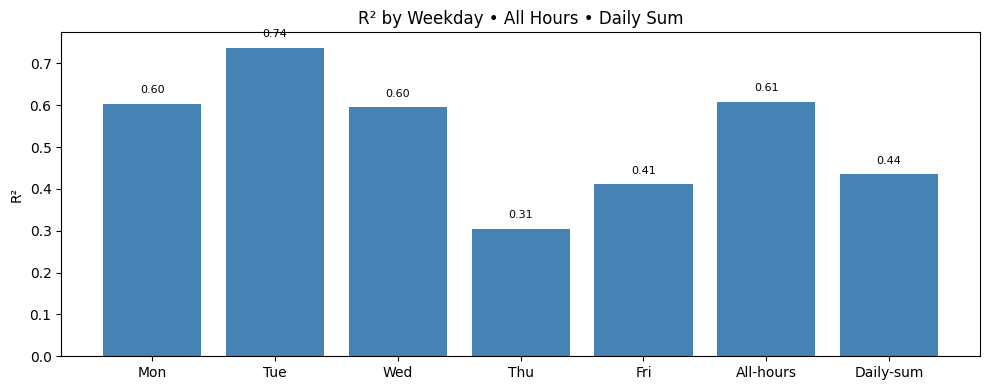

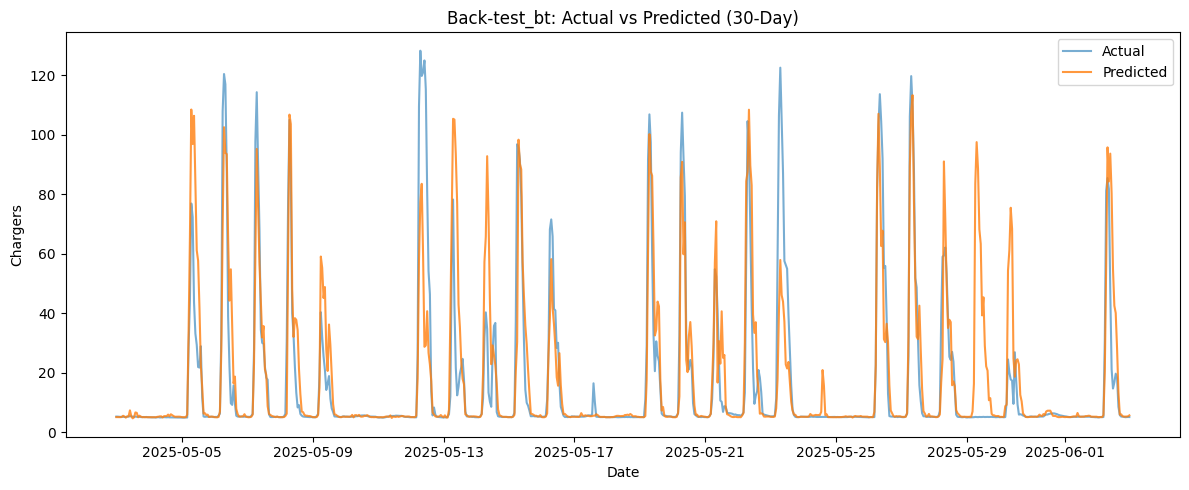

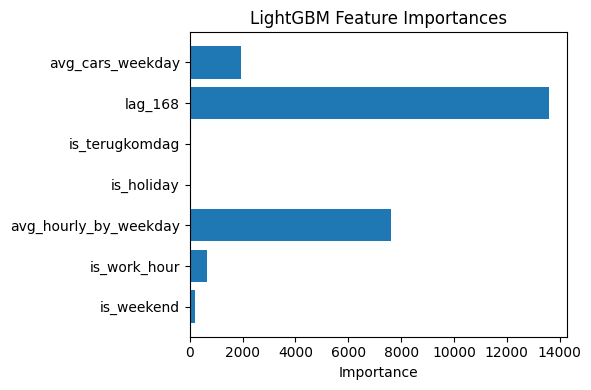

✓ Model saved to ./final_pipeline/charging_model.pkl


In [7]:
import pandas as pd, numpy as np, holidays, lightgbm as lgb, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os          # NEW
import joblib      # NEW


# ─────────────────────── 1  LOAD DATA ───────────────────────
df = pd.read_csv("./final_pipeline/api_data/aggregated_hourly_measurements.csv")

# ── NEW: round every numeric column to two decimals ──
num_cols = df.select_dtypes(include=["number"]).columns          # float & int
df[num_cols] = df[num_cols].round(2)

df['ds'] = pd.to_datetime(df['Hour'])
df = df.sort_values('ds').rename(columns={'Chargers': 'y'})




# ─────────────────────── 2  STATIC FLAGS ─────────────────────
tkd = pd.to_datetime([
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]).normalize()
be_holidays = holidays.Belgium(years=df['ds'].dt.year.unique())

df['is_terugkomdag'] = df['ds'].dt.normalize().isin(tkd).astype(int)
df['is_holiday']     = df['ds'].dt.normalize().isin(be_holidays).astype(int)

# core time flags
df['weekday']      = df['ds'].dt.weekday
df['hour']         = df['ds'].dt.hour
df['is_weekend']   = (df['weekday'] >= 5).astype(int)
df['is_work_hour'] = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)

SESSION_KWH = 9.5                         # average energy per vehicle-session

# 30-day evaluation window
start_eval = df['ds'].max() - pd.Timedelta(days=30)
days_iter  = pd.date_range(start_eval.normalize(),
                           df['ds'].max().normalize(),
                           freq='D')

all_preds = []                            # collect daily predictions

for day in days_iter:
    day_start = pd.Timestamp(day)         # 00:00 of target day
    day_end   = day_start + pd.Timedelta(days=1)

    # ──  TRAIN slice: everything before 00:00 of this day  ──
    train = df[df['ds'] < day_start].copy()
    # derive weekday/hour mean & weekday car average on **train only**
    avg_map = (train.groupby(['weekday','hour'])['y']
                     .mean().rename('avg_hourly_by_weekday')
                     .reset_index())
    train['lag_168'] = train['y'].shift(168).fillna(train['y'].mean())                      # fallback mean
    
    train = train.merge(avg_map, on=['weekday','hour'], how='left')
    train['avg_cars_weekday'] = (
        train.groupby('weekday')['y'].transform('mean') / SESSION_KWH
    )

    FEATURES = [
        'is_weekend','is_work_hour','avg_hourly_by_weekday',
        'is_holiday','is_terugkomdag',
        'lag_168','avg_cars_weekday'
    ]

    model = lgb.LGBMRegressor(
        objective='regression', alpha=0.55,
        n_estimators=800, learning_rate=0.05,
        random_state=42
    ).fit(train[FEATURES], train['y'])

    # ──  BUILD feature frame for the 24 h of this day  ──
    day_df = df[(df['ds'] >= day_start) & (df['ds'] < day_end)].copy()
    day_df = day_df.merge(avg_map, on=['weekday','hour'], how='left')

    lag_df = train[['ds','y']].copy()
    lag_df['ds'] = lag_df['ds'] + pd.Timedelta(days=7)
    lag_df.rename(columns={'y':'lag_168'}, inplace=True)
    day_df = day_df.merge(lag_df, on='ds', how='left')
    day_df['lag_168'] = day_df['lag_168'].fillna(day_df['avg_hourly_by_weekday'])

    

    cars_map = (train.groupby('weekday')['y'].mean() / SESSION_KWH
                ).rename('avg_cars_weekday').reset_index()
    day_df = day_df.merge(cars_map, on='weekday', how='left')

    # predict all 24 rows
    day_df['yhat'] = model.predict(day_df[FEATURES])
    all_preds.append(day_df[['ds','y','yhat','weekday']])

# ────────── CONCAT results & evaluate ──────────
test_bt = pd.concat(all_preds).sort_values('ds').reset_index(drop=True)

# ═════════════════ 7. METRICS ════════════════════════════════════════════════
mae  = mean_absolute_error(test_bt['y'], test_bt['yhat'])
rmse = np.sqrt(mean_squared_error(test_bt['y'], test_bt['yhat']))
r2   = r2_score(test_bt['y'], test_bt['yhat'])

print("\n--- Back-test_bt Metrics (Last 30 Days) ---")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.2f}")

# R² by weekday
weekday_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri'}
r2_by_wd = {
    weekday_map[d]:
    r2_score(
        test_bt.loc[test_bt['weekday']==d,'y'],
        test_bt.loc[test_bt['weekday']==d,'yhat']
    )
    for d in range(5)
}

# R² on daily sums
daily = test_bt.groupby(test_bt['ds'].dt.date).agg(
    y_sum=('y','sum'),
    yhat_sum=('yhat','sum')
)
r2_daily = r2_score(daily['y_sum'], daily['yhat_sum'])

# ═════════════════ 8. PLOTS ════════════════════════════════════════════════
# R² bar plot
labels = list(r2_by_wd.keys()) + ['All-hours','Daily-sum']
values = list(r2_by_wd.values()) + [r2, r2_daily]
plt.figure(figsize=(10,4))
bars = plt.bar(labels, values, color='steelblue')
plt.axhline(0, color='k', linewidth=0.7)
plt.ylabel("R²")
plt.title("R² by Weekday • All Hours • Daily Sum")
for bar, v in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.02, f"{v:.2f}",
             ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

# Time-series plot & feature importances
plt.figure(figsize=(12,5))
plt.plot(test_bt['ds'], test_bt['y'],    label='Actual',    alpha=0.6)
plt.plot(test_bt['ds'], test_bt['yhat'], label='Predicted', alpha=0.8)
plt.title("Back-test_bt: Actual vs Predicted (30-Day)")
plt.xlabel("Date")
plt.ylabel("Chargers")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.barh(FEATURES, model.feature_importances_)
plt.title("LightGBM Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# ═════════════════ 12. SAVE FINAL MODEL ═════════════════════════════════════
os.makedirs("./final_pipeline", exist_ok=True)   # ensure folder exists
joblib.dump(model, "./final_pipeline/charging_model.pkl")     # save the last-trained model
print("✓ Model saved to ./final_pipeline/charging_model.pkl")

c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
 


──────── BACK-TEST (Last 30 Days) ─────────
XGB    – MAE 3.338  RMSE 7.896  R² 0.895
FFBPNN – MAE 4.263  RMSE 9.406  R² 0.851
Blend  – MAE 3.515  RMSE 7.994  R² 0.893


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


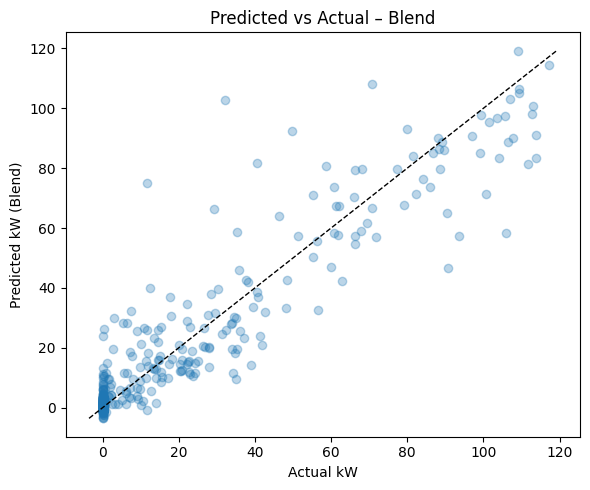

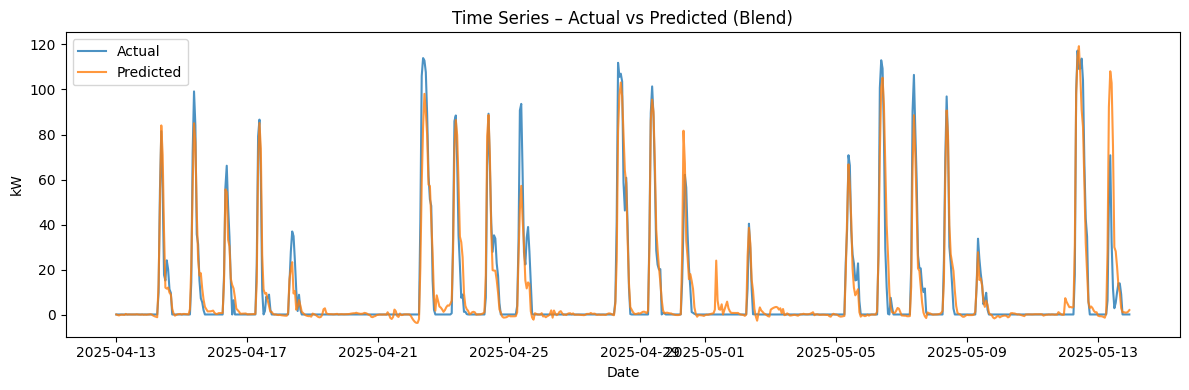

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Workplace-charging load forecasting
‒ Baseline: XGBoost
‒ Additional model: Feed-Forward Back-Propagation Neural Network (FFBPNN)
"""

# ───────────────────────── imports ──────────────────────────
import numpy as np
import pandas as pd
import holidays
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# ───────────────────────── config ───────────────────────────
CHARGING_FILE   = "./charging_forecasts/Charging_data_hourly.csv"
CALENDAR_FILE   = "./hourly_predictions/layout1_full_calendar_2023-2025.csv"
TOTAL_HEADCOUNT = 105
SESSION_KWH     = 9.5
RANDOM_STATE    = 42

# ───────────── 1. LOAD CHARGING DATA ──────────────
df = (
    pd.read_csv(CHARGING_FILE)
      .rename(columns={"Date": "ds", "Chargers": "y"})
)
df["ds"]       = pd.to_datetime(df["ds"])
df             = df.sort_values("ds").reset_index(drop=True)
df["cal_date"] = df["ds"].dt.date

# ───────────── 2. LOAD WORKFORCE CALENDAR ─────────
cal = (
    pd.read_csv(CALENDAR_FILE, parse_dates=["Datum"])
      .rename(columns={
          "Totaal_Vakantiedagen":  "vacation_cnt",
          "Totaal_Thuiswerkdagen": "homework_cnt"
      })
)
cal["cal_date"] = cal["Datum"].dt.date
df = df.merge(
    cal[["cal_date", "vacation_cnt", "homework_cnt"]],
    on="cal_date", how="left"
)
df[["vacation_cnt","homework_cnt"]] = (
    df[["vacation_cnt","homework_cnt"]].fillna(0).astype(int)
)

# ───────────── 3. TIME & HOLIDAY FLAGS ──────────
tkd = pd.to_datetime([
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06"
]).normalize()
be_holidays = holidays.Belgium(years=df["ds"].dt.year.unique())

df["weekday"]        = df["ds"].dt.weekday
df["hour"]           = df["ds"].dt.hour
df["is_weekend"]     = (df["weekday"] >= 5).astype(int)
df["is_work_hour"]   = df["hour"].between(8,18).astype(int)
df["is_holiday"]     = df["ds"].dt.normalize().isin(be_holidays).astype(int)
df["is_terugkomdag"] = df["ds"].dt.normalize().isin(tkd).astype(int)

# ───────── 4. WORK-AT-OFFICE FEATURE ──────────────
is_workday  = (df["weekday"] < 5) & (df["is_holiday"] == 0)
is_workhour = df["is_work_hour"] == 1
df["work_at_office"] = np.where(
    is_workday & is_workhour,
    (TOTAL_HEADCOUNT - df["vacation_cnt"] - df["homework_cnt"]).clip(lower=0),
    0
)

# ───────── 5. STATISTICAL-MOMENT FEATURES ─────────
for win in (24, 168):  # 24 h and 7×24 h windows
    r = df["y"].rolling(win, min_periods=1)
    df[f"m1_{win}h"] = r.mean()
    df[f"m2_{win}h"] = r.var()
    df[f"m3_{win}h"] = r.skew()
    df[f"m4_{win}h"] = r.kurt()

# ───────── 6. CYCLIC ENCODINGS ───────────
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

# ───────── 7. BACK-TEST SETUP ────────────
start_eval = df["ds"].max() - pd.Timedelta(days=30)
days_iter  = pd.date_range(start_eval.normalize(),
                           df["ds"].max().normalize(), freq="D")

scaler = StandardScaler()
xgb_preds, nn_preds = [], []

# Predictor list
FEATURES = [
    "is_work_hour","is_weekend","is_holiday","is_terugkomdag",
    "work_at_office","lag_168","avg_hourly_by_weekday","avg_cars_weekday",
    "hour_sin","hour_cos"
] + [f"m{i}_{w}h" for i in range(1,5) for w in (24,168)]

for day in days_iter:
    # split into train vs test-day
    day_start = pd.Timestamp(day)
    train = df[df["ds"] < day_start].copy()

    # hourly average map
    avg_map = (
        train.groupby(["weekday","hour"])["y"]
             .mean()
             .rename("avg_hourly_by_weekday")
             .reset_index()
    )

    # add lag & avg cars
    train["lag_168"] = train["y"].shift(168).fillna(train["y"].mean())
    train = train.merge(avg_map, on=["weekday","hour"], how="left")
    train["avg_cars_weekday"] = (
        train.groupby("weekday")["y"].transform("mean") / SESSION_KWH
    )

    # drop NaNs for NN training
    train_model = train.dropna(subset=FEATURES + ["y"]).copy()

    # ── XGBOOST ──
    xgb_model = xgb.XGBRegressor(
        n_estimators=800, learning_rate=0.05, max_depth=6,
        objective="reg:squarederror", random_state=RANDOM_STATE,
        verbosity=0
    )
    xgb_model.fit(train_model[FEATURES], train_model["y"])

    # prepare test-day
    day_df = df[
        (df["ds"] >= day_start) &
        (df["ds"] <  day_start + pd.Timedelta(days=1))
    ].copy()
    day_df = day_df.merge(avg_map, on=["weekday","hour"], how="left")

    lag_df = train[["ds","y"]].copy()
    lag_df["ds"] += pd.Timedelta(days=7)
    lag_df.rename(columns={"y":"lag_168"}, inplace=True)
    day_df = day_df.merge(lag_df, on="ds", how="left")
    day_df["lag_168"].fillna(day_df["avg_hourly_by_weekday"], inplace=True)

    cars_map = (
        train.groupby("weekday")["y"].mean()/SESSION_KWH
    ).rename("avg_cars_weekday").reset_index()
    day_df = day_df.merge(cars_map, on="weekday", how="left")

    # ── FFBPNN ──
    X_tr = scaler.fit_transform(train_model[FEATURES].values)
    X_te = scaler.transform(day_df[FEATURES].values)

    nn = MLPRegressor(
        hidden_layer_sizes=(30,15),
        activation='tanh', solver='adam',
        learning_rate_init=1e-3,
        max_iter=1000,
        n_iter_no_change=20,
        random_state=RANDOM_STATE
    )
    nn.fit(X_tr, train_model["y"])

    # collect preds
    day_df["yhat_xgb"]   = xgb_model.predict(day_df[FEATURES])
    day_df["yhat_nn"]    = nn.predict(X_te)
    day_df["yhat_blend"] = 0.6*day_df["yhat_xgb"] + 0.4*day_df["yhat_nn"]

    xgb_preds.append(day_df[["ds","y","yhat_xgb"]])
    nn_preds.append(day_df[["yhat_nn","yhat_blend"]])

# ───────── 8. MERGE & EVALUATE ───────────────────────
xgb_df = pd.concat(xgb_preds).reset_index(drop=True)
nn_df  = pd.concat(nn_preds).reset_index(drop=True)
test_bt = pd.concat([xgb_df, nn_df], axis=1)

def metrics(obs, pred):
    return (
        mean_absolute_error(obs, pred),
        np.sqrt(mean_squared_error(obs, pred)),
        r2_score(obs, pred)
    )

mae_xgb, rmse_xgb, r2_xgb   = metrics(test_bt["y"], test_bt["yhat_xgb"])
mae_nn,  rmse_nn,  r2_nn    = metrics(test_bt["y"], test_bt["yhat_nn"])
mae_bl,  rmse_bl,  r2_bl    = metrics(test_bt["y"], test_bt["yhat_blend"])

print("\n──────── BACK-TEST (Last 30 Days) ─────────")
print(f"XGB    – MAE {mae_xgb:.3f}  RMSE {rmse_xgb:.3f}  R² {r2_xgb:.3f}")
print(f"FFBPNN – MAE {mae_nn :.3f}  RMSE {rmse_nn:.3f}  R² {r2_nn :.3f}")
print(f"Blend  – MAE {mae_bl :.3f}  RMSE {rmse_bl:.3f}  R² {r2_bl:.3f}")

# ───────── 9. PLOTS ────────────────────────────────

# 9a. Blend vs Actual scatter
plt.figure(figsize=(6,5))
plt.scatter(test_bt["y"], test_bt["yhat_blend"], alpha=0.3)
lims = [
    min(test_bt["y"].min(), test_bt["yhat_blend"].min()),
    max(test_bt["y"].max(), test_bt["yhat_blend"].max())
]
plt.plot(lims, lims, 'k--', lw=1)
plt.xlabel("Actual kW")
plt.ylabel("Predicted kW (Blend)")
plt.title("Predicted vs Actual – Blend")
plt.tight_layout()
plt.show()

# 9b. Time series: Actual vs Predicted Blend
plt.figure(figsize=(12,4))
plt.plot(test_bt["ds"], test_bt["y"],    label="Actual",   alpha=0.8)
plt.plot(test_bt["ds"], test_bt["yhat_blend"], label="Predicted", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("kW")
plt.title("Time Series – Actual vs Predicted (Blend)")
plt.legend()
plt.tight_layout()
plt.show()


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
 


── Back-test (last 30 days)
XGB    MAE 4.759  RMSE 10.337  R² 0.832
FFBPNN MAE 5.140  RMSE 9.637  R² 0.854
Blend  MAE 4.411  RMSE 9.272  R² 0.865


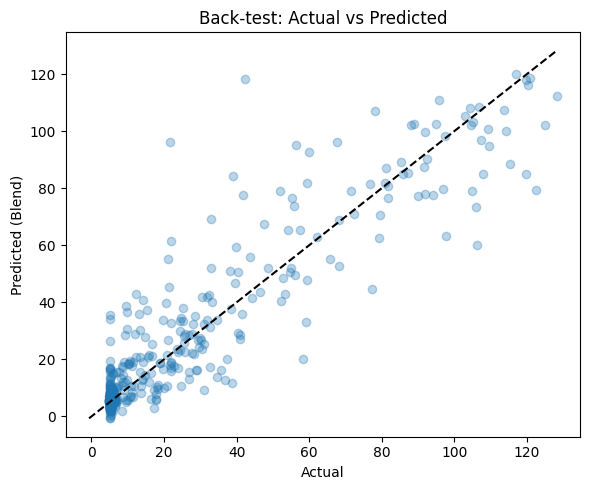

c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


TypeError: Invalid comparison between dtype=datetime64[ns, UTC] and Timestamp

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Workplace-charging load forecasting
‒ Baseline: XGBoost
‒ Feed-Forward Back-Propagation NN (MLPRegressor)
‒ One-day forecast for any date in FORECAST_DATE
"""

# ───────────────────────── imports ──────────────────────────
import numpy as np, pandas as pd, holidays, xgboost as xgb, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import warnings; warnings.filterwarnings("ignore", category=FutureWarning)

# ───────────────────────── user input ───────────────────────
FORECAST_DATE = "2025-05-29"          # <── pick any YYYY-MM-DD

# ───────────────────────── config / files ───────────────────
CHARGING_FILE   = "./final_pipeline/api_data/aggregated_hourly_measurements.csv"
CALENDAR_FILE   = "./hourly_predictions/layout1_full_calendar_2023-2025.csv"
TOTAL_HEADCOUNT = 105
SESSION_KWH     = 9.5
RANDOM_STATE    = 42

# ───────────── 1. LOAD CHARGING DATA ──────────────
df = (pd.read_csv(CHARGING_FILE)
        .rename(columns={"Hour": "ds", "Chargers": "y"}))
df["ds"]       = pd.to_datetime(df["ds"])
df             = df.sort_values("ds").reset_index(drop=True)
df["cal_date"] = df["ds"].dt.date

# ───────────── 2. LOAD WORKFORCE CALENDAR ─────────
cal = (pd.read_csv(CALENDAR_FILE, parse_dates=["Datum"])
         .rename(columns={
             "Totaal_Vakantiedagen":  "vacation_cnt",
             "Totaal_Thuiswerkdagen": "homework_cnt"
         }))
cal["cal_date"] = cal["Datum"].dt.date
df = df.merge(cal[["cal_date","vacation_cnt","homework_cnt"]],
              on="cal_date", how="left")
df[["vacation_cnt","homework_cnt"]] = (
    df[["vacation_cnt","homework_cnt"]].fillna(0).astype(int))

# ───────────── 3. TIME & HOLIDAY FLAGS ──────────
terugkomdagen = pd.to_datetime([
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06"
]).normalize()

years_needed = np.unique(df["ds"].dt.year.tolist() +
                         [pd.Timestamp(FORECAST_DATE).year])
be_holidays = holidays.Belgium(years=years_needed)

def add_time_flags(frame: pd.DataFrame) -> None:
    frame["weekday"]        = frame["ds"].dt.weekday
    frame["hour"]           = frame["ds"].dt.hour
    frame["is_weekend"]     = (frame["weekday"] >= 5).astype(int)
    frame["is_work_hour"]   = frame["hour"].between(8,18).astype(int)
    frame["is_holiday"]     = frame["ds"].dt.normalize().isin(be_holidays).astype(int)
    frame["is_terugkomdag"] = frame["ds"].dt.normalize().isin(terugkomdagen).astype(int)
    frame["hour_sin"]       = np.sin(2*np.pi*frame["hour"]/24)
    frame["hour_cos"]       = np.cos(2*np.pi*frame["hour"]/24)

add_time_flags(df)

# ───────── 4. WORK-AT-OFFICE FEATURE ──────────────
def compute_work_at_office(frame: pd.DataFrame) -> None:
    is_workday  = (frame["weekday"] < 5) & (frame["is_holiday"] == 0)
    is_workhour = frame["is_work_hour"] == 1
    frame["work_at_office"] = np.where(
        is_workday & is_workhour,
        (TOTAL_HEADCOUNT - frame.get("vacation_cnt",0) - frame.get("homework_cnt",0)).clip(lower=0),
        0
    )
compute_work_at_office(df)

# ───────── 5. STATISTICAL-MOMENT FEATURES ─────────
for win in (24,168):
    r = df["y"].rolling(win, min_periods=1)
    df[f"m1_{win}h"] = r.mean()
    df[f"m2_{win}h"] = r.var()
    df[f"m3_{win}h"] = r.skew()
    df[f"m4_{win}h"] = r.kurt()

# ───────── 6. FEATURE LIST ───────────
MOMENT_COLS = [f"m{i}_{w}h" for i in range(1,5) for w in (24,168)]
FEATURES = [
    "is_work_hour","is_weekend","is_holiday","is_terugkomdag",
    "work_at_office","lag_168","avg_hourly_by_weekday","avg_cars_weekday",
    "hour_sin","hour_cos"
] + MOMENT_COLS

# ───────── 7. 30-DAY ROLLING BACK-TEST ────────────
start_eval = df["ds"].max() - pd.Timedelta(days=30)
days_iter  = pd.date_range(start_eval.normalize(),
                           df["ds"].max().normalize(), freq="D")

xgb_preds, nn_preds = [], []
scaler = StandardScaler()

for day in days_iter:
    day_start = pd.Timestamp(day)
    train = df[df["ds"] < day_start].copy()

    avg_map = (train.groupby(["weekday","hour"])["y"]
                     .mean()
                     .rename("avg_hourly_by_weekday")
                     .reset_index())

    train["lag_168"] = train["y"].shift(168).fillna(train["y"].mean())
    train = train.merge(avg_map, on=["weekday","hour"], how="left")
    train["avg_cars_weekday"] = (train.groupby("weekday")["y"]
                                   .transform("mean")/SESSION_KWH)

    train_model = train.dropna(subset=FEATURES+["y"]).copy()

    xgb_model = xgb.XGBRegressor(n_estimators=800, learning_rate=0.05,
                                 max_depth=6, objective="reg:squarederror",
                                 random_state=RANDOM_STATE, verbosity=0)
    xgb_model.fit(train_model[FEATURES], train_model["y"])

    # assemble test-day frame
    day_df = df[(df["ds"]>=day_start)&(df["ds"]<day_start+pd.Timedelta(days=1))].copy()
    day_df = day_df.merge(avg_map,on=["weekday","hour"],how="left")

    lag_df = train[["ds","y"]].copy(); lag_df["ds"] += pd.Timedelta(days=7)
    day_df = day_df.merge(lag_df.rename(columns={"y":"lag_168"}),
                          on="ds", how="left")
    day_df["lag_168"].fillna(day_df["avg_hourly_by_weekday"], inplace=True)

    cars_map = (train.groupby("weekday")["y"].mean()/SESSION_KWH
               ).rename("avg_cars_weekday").reset_index()
    day_df = day_df.merge(cars_map,on="weekday",how="left")

    X_tr = scaler.fit_transform(train_model[FEATURES].values)
    X_te = scaler.transform(day_df[FEATURES].values)
    nn = MLPRegressor(hidden_layer_sizes=(30,15), activation='tanh',
                      solver='adam', learning_rate_init=1e-3,
                      max_iter=1000, n_iter_no_change=20,
                      random_state=RANDOM_STATE)
    nn.fit(X_tr, train_model["y"])

    day_df["yhat_xgb"]   = xgb_model.predict(day_df[FEATURES])
    day_df["yhat_nn"]    = nn.predict(X_te)
    day_df["yhat_blend"] = 0.6*day_df["yhat_xgb"] + 0.4*day_df["yhat_nn"]

    xgb_preds.append(day_df[["ds","y","yhat_xgb"]])
    nn_preds.append(day_df[["yhat_nn","yhat_blend"]])

# back-test metrics & plot
test_bt = pd.concat([pd.concat(xgb_preds).reset_index(drop=True),
                     pd.concat(nn_preds).reset_index(drop=True)], axis=1)

def m(obs, pred):
    return (mean_absolute_error(obs,pred),
            np.sqrt(mean_squared_error(obs,pred)),
            r2_score(obs,pred))
mae_x, rmse_x, r2_x = m(test_bt["y"], test_bt["yhat_xgb"])
mae_n, rmse_n, r2_n = m(test_bt["y"], test_bt["yhat_nn"])
mae_b, rmse_b, r2_b = m(test_bt["y"], test_bt["yhat_blend"])
print("\n── Back-test (last 30 days)")
print(f"XGB    MAE {mae_x:.3f}  RMSE {rmse_x:.3f}  R² {r2_x:.3f}")
print(f"FFBPNN MAE {mae_n:.3f}  RMSE {rmse_n:.3f}  R² {r2_n:.3f}")
print(f"Blend  MAE {mae_b:.3f}  RMSE {rmse_b:.3f}  R² {r2_b:.3f}")

plt.figure(figsize=(6,5))
plt.scatter(test_bt["y"], test_bt["yhat_blend"], alpha=0.3)
lims=[min(test_bt["y"].min(),test_bt["yhat_blend"].min()),
      max(test_bt["y"].max(),test_bt["yhat_blend"].max())]
plt.plot(lims,lims,'k--'); plt.xlabel("Actual"); plt.ylabel("Predicted (Blend)")
plt.title("Back-test: Actual vs Predicted"); plt.tight_layout(); plt.show()

# ───────── 8. FINAL MODELS ON ALL HISTORY ─────────
avg_map_full = (df.groupby(["weekday","hour"])["y"]
                .mean().rename("avg_hourly_by_weekday").reset_index())
df["lag_168"] = df["y"].shift(168).fillna(df["y"].mean())
df = df.merge(avg_map_full, on=["weekday","hour"], how="left")
df["avg_cars_weekday"] = (df.groupby("weekday")["y"].transform("mean")/SESSION_KWH)
full_data = df.dropna(subset=FEATURES+["y"]).copy()

final_xgb = xgb.XGBRegressor(n_estimators=800, learning_rate=0.05,
                             max_depth=6, objective="reg:squarederror",
                             random_state=RANDOM_STATE, verbosity=0)
final_xgb.fit(full_data[FEATURES], full_data["y"])

final_scaler = StandardScaler()
X_full = final_scaler.fit_transform(full_data[FEATURES].values)
final_nn = MLPRegressor(hidden_layer_sizes=(30,15), activation='tanh',
                        solver='adam', learning_rate_init=1e-3,
                        max_iter=1000, n_iter_no_change=20,
                        random_state=RANDOM_STATE)
final_nn.fit(X_full, full_data["y"])

# ───────── 9. BUILD FORECAST FRAME ────────────────
def build_forecast_frame(date_str: str) -> pd.DataFrame:
    start = pd.Timestamp(date_str)
    hours = pd.date_range(start, start+pd.Timedelta(hours=23), freq="H")
    fdf   = pd.DataFrame({"ds": hours})
    fdf["cal_date"] = fdf["ds"].dt.date
    fdf = fdf.merge(cal[["cal_date","vacation_cnt","homework_cnt"]],
                    on="cal_date", how="left")
    fdf[["vacation_cnt","homework_cnt"]] = (
        fdf[["vacation_cnt","homework_cnt"]].fillna(0).astype(int))

    add_time_flags(fdf); compute_work_at_office(fdf)
    fdf = fdf.merge(avg_map_full, on=["weekday","hour"], how="left")

    # -- FIX: remove duplicate timestamps before lookup ----------
    hist_y_series = df.groupby("ds")["y"].mean()    # unique index ✔
    lag_values = hist_y_series.reindex(fdf["ds"] - pd.Timedelta(hours=168))
    fdf["lag_168"] = lag_values.values
    fdf["lag_168"].fillna(hist_y_series.mean(), inplace=True)
    # -------------------------------------------------------------

    fdf = fdf.merge(
        (df.groupby("weekday")["y"].mean()/SESSION_KWH
          ).rename("avg_cars_weekday").reset_index(),
        on="weekday", how="left"
    )

    # rolling moments (also using deduplicated series)
    for idx, ts in enumerate(fdf["ds"]):
        hist = hist_y_series[hist_y_series.index < ts]
        for win in (24,168):
            window = hist.tail(win)
            fdf.loc[idx, f"m1_{win}h"] = window.mean()
            fdf.loc[idx, f"m2_{win}h"] = window.var()
            fdf.loc[idx, f"m3_{win}h"] = window.skew()
            fdf.loc[idx, f"m4_{win}h"] = window.kurt()
    return fdf

forecast_df = build_forecast_frame(FORECAST_DATE)

# ───────── 10. PREDICT FORECAST DAY ───────────────
forecast_df["yhat_xgb"] = final_xgb.predict(forecast_df[FEATURES])
forecast_df["yhat_nn"]  = final_nn.predict(final_scaler.transform(
                                           forecast_df[FEATURES].values))
forecast_df["yhat_blend"] = 0.6*forecast_df["yhat_xgb"] + 0.4*forecast_df["yhat_nn"]

# attach actuals if present
mask = df["cal_date"] == pd.to_datetime(FORECAST_DATE).date()
if mask.any():
    actuals = df.loc[mask, ["ds","y"]]
    forecast_df = forecast_df.merge(actuals, on="ds", how="left")

# ───────── 11. PLOT FORECAST ──────────────────────
plt.figure(figsize=(12,4))
plt.plot(forecast_df["ds"], forecast_df["yhat_blend"],
         label="Predicted", color="tab:orange")

if "y" in forecast_df.columns:
    plt.plot(forecast_df["ds"], forecast_df["y"],
             label="Actual", color="tab:blue")
    plt.title(f"{FORECAST_DATE} – Actual vs Predicted")
else:
    plt.title(f"{FORECAST_DATE} – Forecast (no actual data yet)")

plt.xlabel("Hour"); plt.ylabel("kW"); plt.legend(); plt.tight_layout(); plt.show()



── Back-test (last 30 days)
XGB MAE 3.338  RMSE 7.896  R² 0.895


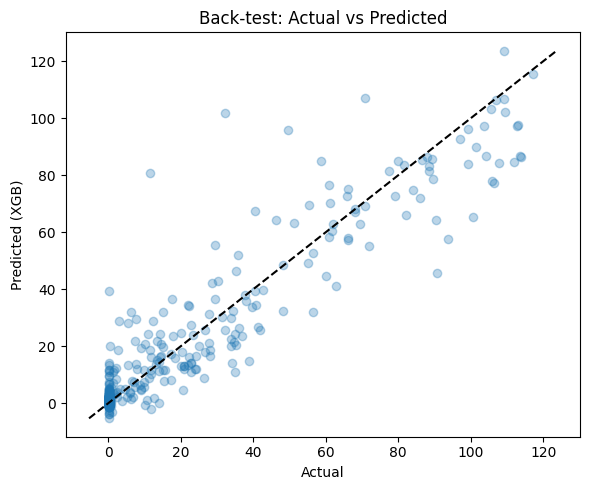

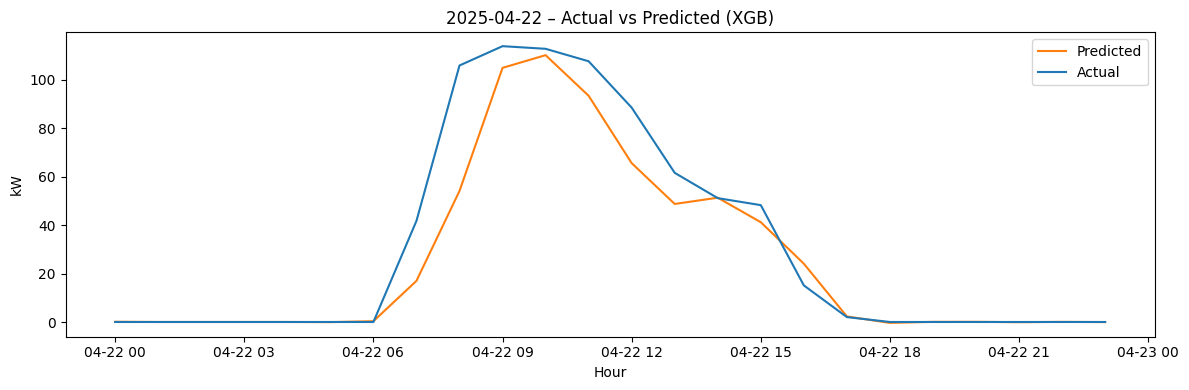

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Workplace-charging load forecasting
• Model: XGBoost only   (neural-network removed)
• Supports:
  – 30-day rolling back-test
  – One-day forecast for any date via FORECAST_DATE
"""

# ───────────────────────── imports ───────────────────────────
import numpy as np, pandas as pd, holidays, xgboost as xgb, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings; warnings.filterwarnings("ignore", category=FutureWarning)

# ───────────────────────── user input ────────────────────────
FORECAST_DATE = "2025-04-22"        # ← choose any YYYY-MM-DD (past or future)

# ───────────────────────── config / files ────────────────────
CHARGING_FILE   = "./charging_forecasts/Charging_data_hourly.csv"
CALENDAR_FILE   = "./hourly_predictions/layout1_full_calendar_2023-2025.csv"
TOTAL_HEADCOUNT = 105
SESSION_KWH     = 9.5
RANDOM_STATE    = 42

# ───────────── 1. LOAD CHARGING DATA ──────────────
df = (pd.read_csv(CHARGING_FILE)
        .rename(columns={"Date": "ds", "Chargers": "y"}))
df["ds"]       = pd.to_datetime(df["ds"])
df             = df.sort_values("ds").reset_index(drop=True)
df["cal_date"] = df["ds"].dt.date

# ───────────── 2. LOAD WORKFORCE CALENDAR ─────────
cal = (pd.read_csv(CALENDAR_FILE, parse_dates=["Datum"])
         .rename(columns={
             "Totaal_Vakantiedagen":  "vacation_cnt",
             "Totaal_Thuiswerkdagen": "homework_cnt"
         }))
cal["cal_date"] = cal["Datum"].dt.date
df = df.merge(cal[["cal_date","vacation_cnt","homework_cnt"]],
              on="cal_date", how="left")
df[["vacation_cnt","homework_cnt"]] = (
    df[["vacation_cnt","homework_cnt"]].fillna(0).astype(int))

# ───────────── 3. TIME & HOLIDAY FLAGS ──────────
terugkomdagen = pd.to_datetime([
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06"
]).normalize()

years_needed = np.unique(df["ds"].dt.year.tolist() +
                         [pd.Timestamp(FORECAST_DATE).year])
be_holidays = holidays.Belgium(years=years_needed)

def add_time_flags(frame: pd.DataFrame) -> None:
    frame["weekday"]        = frame["ds"].dt.weekday
    frame["hour"]           = frame["ds"].dt.hour
    frame["is_weekend"]     = (frame["weekday"] >= 5).astype(int)
    frame["is_work_hour"]   = frame["hour"].between(8,18).astype(int)
    frame["is_holiday"]     = frame["ds"].dt.normalize().isin(be_holidays).astype(int)
    frame["is_terugkomdag"] = frame["ds"].dt.normalize().isin(terugkomdagen).astype(int)
    frame["hour_sin"]       = np.sin(2*np.pi*frame["hour"]/24)
    frame["hour_cos"]       = np.cos(2*np.pi*frame["hour"]/24)

add_time_flags(df)

# ───────── 4. WORK-AT-OFFICE FEATURE ──────────────
def compute_work_at_office(frame: pd.DataFrame) -> None:
    is_workday  = (frame["weekday"] < 5) & (frame["is_holiday"] == 0)
    is_workhour = frame["is_work_hour"] == 1
    frame["work_at_office"] = np.where(
        is_workday & is_workhour,
        (TOTAL_HEADCOUNT - frame.get("vacation_cnt",0) - frame.get("homework_cnt",0)).clip(lower=0),
        0
    )
compute_work_at_office(df)

# ───────── 5. STATISTICAL-MOMENT FEATURES ─────────
for win in (24,168):
    r = df["y"].rolling(win, min_periods=1)
    df[f"m1_{win}h"] = r.mean()
    df[f"m2_{win}h"] = r.var()
    df[f"m3_{win}h"] = r.skew()
    df[f"m4_{win}h"] = r.kurt()

# ───────── 6. FEATURE LIST ───────────
MOMENT_COLS = [f"m{i}_{w}h" for i in range(1,5) for w in (24,168)]
FEATURES = [
    "is_work_hour","is_weekend","is_holiday","is_terugkomdag",
    "work_at_office","lag_168","avg_hourly_by_weekday","avg_cars_weekday",
    "hour_sin","hour_cos"
] + MOMENT_COLS

# ───────── 7. 30-DAY ROLLING BACK-TEST ────────────
start_eval = df["ds"].max() - pd.Timedelta(days=30)
days_iter  = pd.date_range(start_eval.normalize(),
                           df["ds"].max().normalize(), freq="D")

bt_results = []

for day in days_iter:
    day_start = pd.Timestamp(day)
    train = df[df["ds"] < day_start].copy()

    # hourly average map
    avg_map = (train.groupby(["weekday","hour"])["y"]
                     .mean()
                     .rename("avg_hourly_by_weekday")
                     .reset_index())

    train["lag_168"] = train["y"].shift(168).fillna(train["y"].mean())
    train = train.merge(avg_map, on=["weekday","hour"], how="left")
    train["avg_cars_weekday"] = (train.groupby("weekday")["y"]
                                   .transform("mean")/SESSION_KWH)

    train_model = train.dropna(subset=FEATURES+["y"]).copy()

    xgb_model = xgb.XGBRegressor(
        n_estimators=800, learning_rate=0.05, max_depth=6,
        objective="reg:squarederror", random_state=RANDOM_STATE, verbosity=0)
    xgb_model.fit(train_model[FEATURES], train_model["y"])

    # test-day frame
    day_df = df[(df["ds"]>=day_start)&(df["ds"]<day_start+pd.Timedelta(days=1))].copy()
    day_df = day_df.merge(avg_map,on=["weekday","hour"],how="left")

    lag_df = train[["ds","y"]].copy(); lag_df["ds"] += pd.Timedelta(days=7)
    day_df = day_df.merge(lag_df.rename(columns={"y":"lag_168"}),
                          on="ds", how="left")
    day_df["lag_168"].fillna(day_df["avg_hourly_by_weekday"], inplace=True)

    cars_map = (train.groupby("weekday")["y"].mean()/SESSION_KWH
               ).rename("avg_cars_weekday").reset_index()
    day_df = day_df.merge(cars_map,on="weekday",how="left")

    day_df["yhat_xgb"] = xgb_model.predict(day_df[FEATURES])
    bt_results.append(day_df[["ds","y","yhat_xgb"]])

# back-test metrics & plot
test_bt = pd.concat(bt_results).reset_index(drop=True)

mae   = mean_absolute_error(test_bt["y"], test_bt["yhat_xgb"])
rmse  = np.sqrt(mean_squared_error(test_bt["y"], test_bt["yhat_xgb"]))
r2    = r2_score(test_bt["y"], test_bt["yhat_xgb"])
print("\n── Back-test (last 30 days)")
print(f"XGB MAE {mae:.3f}  RMSE {rmse:.3f}  R² {r2:.3f}")

plt.figure(figsize=(6,5))
plt.scatter(test_bt["y"], test_bt["yhat_xgb"], alpha=0.3)
lims=[min(test_bt["y"].min(),test_bt["yhat_xgb"].min()),
      max(test_bt["y"].max(),test_bt["yhat_xgb"].max())]
plt.plot(lims,lims,'k--'); plt.xlabel("Actual"); plt.ylabel("Predicted (XGB)")
plt.title("Back-test: Actual vs Predicted"); plt.tight_layout(); plt.show()

# ───────── 8. FINAL XGB MODEL ON FULL HISTORY ─────
avg_map_full = (df.groupby(["weekday","hour"])["y"]
                .mean().rename("avg_hourly_by_weekday").reset_index())
df["lag_168"] = df["y"].shift(168).fillna(df["y"].mean())
df = df.merge(avg_map_full, on=["weekday","hour"], how="left")
df["avg_cars_weekday"] = (df.groupby("weekday")["y"].transform("mean")/SESSION_KWH)
full_data = df.dropna(subset=FEATURES+["y"]).copy()

final_xgb = xgb.XGBRegressor(
    n_estimators=800, learning_rate=0.05, max_depth=6,
    objective="reg:squarederror", random_state=RANDOM_STATE, verbosity=0)
final_xgb.fit(full_data[FEATURES], full_data["y"])

# ───────── 9. BUILD FORECAST FRAME ────────────────
def build_forecast_frame(date_str: str) -> pd.DataFrame:
    start = pd.Timestamp(date_str)
    hours = pd.date_range(start, start+pd.Timedelta(hours=23), freq="H")
    fdf   = pd.DataFrame({"ds": hours})
    fdf["cal_date"] = fdf["ds"].dt.date
    fdf = fdf.merge(cal[["cal_date","vacation_cnt","homework_cnt"]],
                    on="cal_date", how="left")
    fdf[["vacation_cnt","homework_cnt"]] = (
        fdf[["vacation_cnt","homework_cnt"]].fillna(0).astype(int))

    add_time_flags(fdf); compute_work_at_office(fdf)
    fdf = fdf.merge(avg_map_full, on=["weekday","hour"], how="left")

    # unique index series to avoid duplicate-label error
    hist_series = df.groupby("ds")["y"].mean()

    # 168-h lag
    lag_vals = hist_series.reindex(fdf["ds"] - pd.Timedelta(hours=168))
    fdf["lag_168"] = lag_vals.values
    fdf["lag_168"].fillna(hist_series.mean(), inplace=True)

    fdf = fdf.merge(
        (df.groupby("weekday")["y"].mean()/SESSION_KWH
          ).rename("avg_cars_weekday").reset_index(),
        on="weekday", how="left"
    )

    # statistical moments from history
    for idx, ts in enumerate(fdf["ds"]):
        hist = hist_series[hist_series.index < ts]
        for win in (24,168):
            window = hist.tail(win)
            fdf.loc[idx, f"m1_{win}h"] = window.mean()
            fdf.loc[idx, f"m2_{win}h"] = window.var()
            fdf.loc[idx, f"m3_{win}h"] = window.skew()
            fdf.loc[idx, f"m4_{win}h"] = window.kurt()
    return fdf

forecast_df = build_forecast_frame(FORECAST_DATE)

# ───────── 10. PREDICT FORECAST DAY ───────────────
forecast_df["yhat_xgb"] = final_xgb.predict(forecast_df[FEATURES])

# attach actuals if present
mask = df["cal_date"] == pd.to_datetime(FORECAST_DATE).date()
if mask.any():
    forecast_df = forecast_df.merge(df.loc[mask, ["ds","y"]], on="ds", how="left")

# ───────── 11. PLOT FORECAST ──────────────────────
plt.figure(figsize=(12,4))
plt.plot(forecast_df["ds"], forecast_df["yhat_xgb"],
         label="Predicted", color="tab:orange")

if "y" in forecast_df.columns:
    plt.plot(forecast_df["ds"], forecast_df["y"],
             label="Actual", color="tab:blue")
    plt.title(f"{FORECAST_DATE} – Actual vs Predicted (XGB)")
else:
    plt.title(f"{FORECAST_DATE} – Forecast (XGB)")

plt.xlabel("Hour"); plt.ylabel("kW"); plt.legend(); plt.tight_layout(); plt.show()



── Back-test (last 30 days)
MAE  3.338   RMSE 7.896   R² 0.895


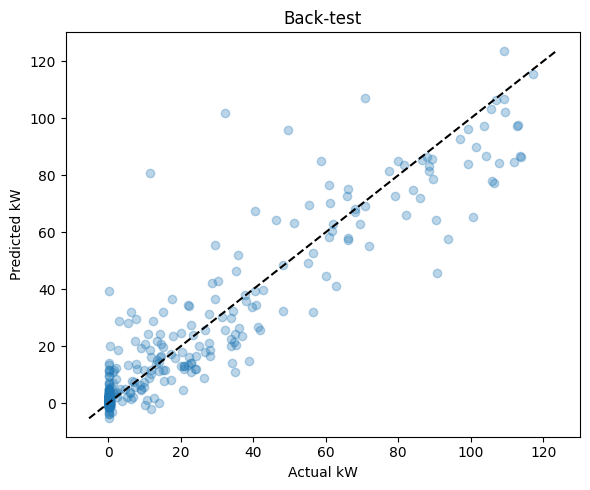

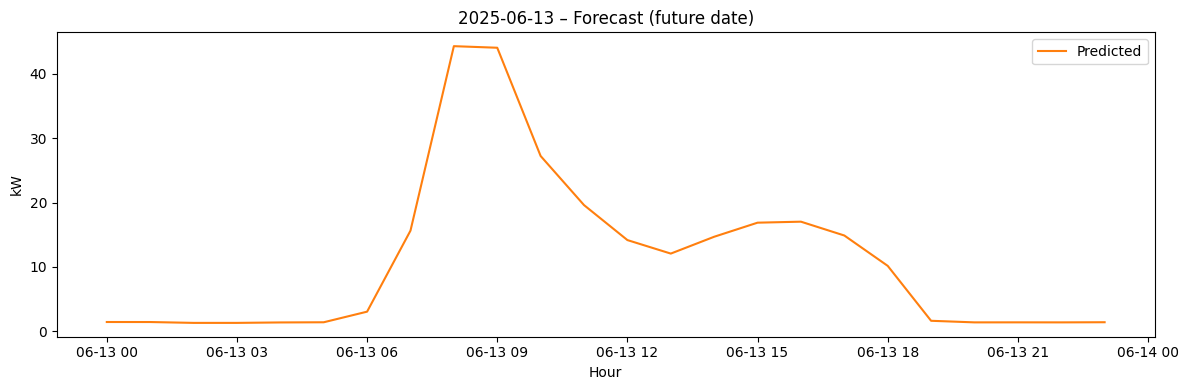

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Workplace-charging load forecasting
-----------------------------------
• Model: XGBoost (tree-based, handles NaNs natively)
• Features: calendar flags, terugkomdagen, cyclic encodings, people-at-office,
            168-h lag, weekday×hour averages, weekday kWh/EV proxy,
            rolling 24 h & 168 h statistical moments
• Two workflows:
  1. 30-day rolling back-test to gauge recent accuracy
  2. One-day forecast for any `FORECAST_DATE`
     – If that date is *in* the data ➜ train on everything *before* the day
     – If that date is in the *future* ➜ train on all history
"""

# ───────────────────────── imports ──────────────────────────
import numpy as np
import pandas as pd
import holidays
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# ────────────────────── user parameters ─────────────────────
FORECAST_DATE = "2025-06-13"          # ← change to any YYYY-MM-DD

# ───────────────────────── config ───────────────────────────
CHARGING_FILE   = "./charging_forecasts/Charging_data_hourly.csv"
CALENDAR_FILE   = "./hourly_predictions/layout1_full_calendar_2023-2025.csv"
TOTAL_HEADCOUNT = 105           # full-time employees
SESSION_KWH     = 9.5           # typical energy per charging session
RANDOM_STATE    = 42

# ═════════════ 1. LOAD HISTORICAL DATA ═════════════
df = (pd.read_csv(CHARGING_FILE)
        .rename(columns={"Date": "ds", "Chargers": "y"}))
df["ds"]       = pd.to_datetime(df["ds"])
df             = df.sort_values("ds").reset_index(drop=True)
df["cal_date"] = df["ds"].dt.date

# workforce vacation / home-office counts
cal = (pd.read_csv(CALENDAR_FILE, parse_dates=["Datum"])
         .rename(columns={
             "Totaal_Vakantiedagen":  "vacation_cnt",
             "Totaal_Thuiswerkdagen": "homework_cnt"
         }))
cal["cal_date"] = cal["Datum"].dt.date
df = df.merge(cal[["cal_date", "vacation_cnt", "homework_cnt"]],
              on="cal_date", how="left")
df[["vacation_cnt", "homework_cnt"]] = (
    df[["vacation_cnt", "homework_cnt"]].fillna(0).astype(int))

# ═════════════ 2. CALENDAR / CYCLIC FLAGS ══════════
terugkomdagen = pd.to_datetime([
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06"
]).normalize()

years_needed = np.unique(df["ds"].dt.year.tolist() +
                         [pd.Timestamp(FORECAST_DATE).year])
be_holidays = holidays.Belgium(years=years_needed)

def add_time_flags(frame: pd.DataFrame) -> None:
    frame["weekday"]        = frame["ds"].dt.weekday
    frame["hour"]           = frame["ds"].dt.hour
    frame["is_weekend"]     = (frame["weekday"] >= 5).astype(int)
    frame["is_work_hour"]   = frame["hour"].between(8, 18).astype(int)
    frame["is_holiday"]     = frame["ds"].dt.normalize().isin(be_holidays).astype(int)
    frame["is_terugkomdag"] = frame["ds"].dt.normalize().isin(terugkomdagen).astype(int)
    frame["hour_sin"]       = np.sin(2*np.pi*frame["hour"]/24)
    frame["hour_cos"]       = np.cos(2*np.pi*frame["hour"]/24)

add_time_flags(df)

# ═════════════ 3. WORK-AT-OFFICE COUNTS ════════════
def compute_work_at_office(frame: pd.DataFrame) -> None:
    is_workday  = (frame["weekday"] < 5) & (frame["is_holiday"] == 0)
    is_workhour = frame["is_work_hour"] == 1
    frame["work_at_office"] = np.where(
        is_workday & is_workhour,
        (TOTAL_HEADCOUNT -
         frame.get("vacation_cnt", 0) -
         frame.get("homework_cnt", 0)).clip(lower=0),
        0
    )

compute_work_at_office(df)

# ═════════════ 4. ROLLING MOMENT FEATURES ══════════
for win in (24, 168):                # 1-day and 1-week windows
    r = df["y"].rolling(win, min_periods=1)
    df[f"m1_{win}h"] = r.mean()
    df[f"m2_{win}h"] = r.var()
    df[f"m3_{win}h"] = r.skew()
    df[f"m4_{win}h"] = r.kurt()

# ═════════════ 5. FEATURE LIST ═════════════════════
MOMENT_COLS = [f"m{i}_{w}h" for i in range(1, 5) for w in (24, 168)]
FEATURES = [
    "is_work_hour", "is_weekend", "is_holiday", "is_terugkomdag",
    "work_at_office", "lag_168", "avg_hourly_by_weekday",
    "avg_cars_weekday", "hour_sin", "hour_cos"
] + MOMENT_COLS

# ═════════════ 6. 30-DAY ROLLING BACK-TEST ═════════
start_eval = df["ds"].max() - pd.Timedelta(days=30)
days_iter  = pd.date_range(start_eval.normalize(),
                           df["ds"].max().normalize(), freq="D")
bt_rows = []

for day in days_iter:
    cut  = pd.Timestamp(day)
    hist = df[df["ds"] < cut].copy()

    # weekday-hour mean map
    avg_map = (hist.groupby(["weekday","hour"])["y"]
                    .mean()
                    .rename("avg_hourly_by_weekday")
                    .reset_index())

    hist["lag_168"] = hist["y"].shift(168).fillna(hist["y"].mean())
    hist = hist.merge(avg_map, on=["weekday","hour"], how="left")
    hist["avg_cars_weekday"] = (
        hist.groupby("weekday")["y"].transform("mean") / SESSION_KWH
    )
    train = hist.dropna(subset=FEATURES+["y"])

    model = xgb.XGBRegressor(
        n_estimators=800, learning_rate=0.05, max_depth=6,
        objective="reg:squarederror", random_state=RANDOM_STATE, verbosity=0)
    model.fit(train[FEATURES], train["y"])

    day_df = df[(df["ds"] >= cut) & (df["ds"] < cut + pd.Timedelta(days=1))].copy()
    day_df = day_df.merge(avg_map, on=["weekday","hour"], how="left")

    lag = hist[["ds","y"]].copy(); lag["ds"] += pd.Timedelta(days=7)
    day_df = day_df.merge(lag.rename(columns={"y":"lag_168"}), on="ds", how="left")
    day_df["lag_168"].fillna(day_df["avg_hourly_by_weekday"], inplace=True)

    cars_map = (hist.groupby("weekday")["y"].mean()/SESSION_KWH
               ).rename("avg_cars_weekday").reset_index()
    day_df = day_df.merge(cars_map, on="weekday", how="left")

    day_df["yhat"] = model.predict(day_df[FEATURES])
    bt_rows.append(day_df[["ds","y","yhat"]])

# back-test metrics
backtest = pd.concat(bt_rows).reset_index(drop=True)
mae   = mean_absolute_error(backtest["y"], backtest["yhat"])
rmse  = np.sqrt(mean_squared_error(backtest["y"], backtest["yhat"]))
r2    = r2_score(backtest["y"], backtest["yhat"])
print("\n── Back-test (last 30 days)")
print(f"MAE  {mae:.3f}   RMSE {rmse:.3f}   R² {r2:.3f}")

plt.figure(figsize=(6,5))
plt.scatter(backtest["y"], backtest["yhat"], alpha=0.3)
lims = [min(backtest[["y","yhat"]].min()), max(backtest[["y","yhat"]].max())]
plt.plot(lims, lims, 'k--')
plt.xlabel("Actual kW"); plt.ylabel("Predicted kW"); plt.title("Back-test")
plt.tight_layout(); plt.show()

# ═════════════ 7. FINAL MODEL (NO LEAKAGE) ════════
def training_slice(data: pd.DataFrame, day: str) -> pd.DataFrame:
    """Return subset strictly before 00:00 of forecast day."""
    cutoff = pd.Timestamp(day).normalize()
    return data[data["ds"] < cutoff]

train_subset = training_slice(df, FORECAST_DATE)

avg_map_sub = (train_subset.groupby(["weekday","hour"])["y"]
               .mean().rename("avg_hourly_by_weekday").reset_index())

train_subset = train_subset.copy()
train_subset["lag_168"] = train_subset["y"].shift(168).fillna(train_subset["y"].mean())
train_subset = train_subset.merge(avg_map_sub, on=["weekday","hour"], how="left")
train_subset["avg_cars_weekday"] = (
    train_subset.groupby("weekday")["y"].transform("mean") / SESSION_KWH
)
final_train = train_subset.dropna(subset=FEATURES+["y"])

final_xgb = xgb.XGBRegressor(
    n_estimators=800, learning_rate=0.05, max_depth=6,
    objective="reg:squarederror", random_state=RANDOM_STATE, verbosity=0)
final_xgb.fit(final_train[FEATURES], final_train["y"])

# ═════════════ 8. BUILD FORECAST FRAME ════════════
def build_forecast_frame(date_str: str) -> pd.DataFrame:
    start = pd.Timestamp(date_str)
    hrs   = pd.date_range(start, start+pd.Timedelta(hours=23), freq="H")
    fdf   = pd.DataFrame({"ds": hrs})
    fdf["cal_date"] = fdf["ds"].dt.date
    fdf = fdf.merge(cal[["cal_date","vacation_cnt","homework_cnt"]],
                    on="cal_date", how="left")
    fdf[["vacation_cnt","homework_cnt"]] = (
        fdf[["vacation_cnt","homework_cnt"]].fillna(0).astype(int))

    add_time_flags(fdf); compute_work_at_office(fdf)
    fdf = fdf.merge(avg_map_sub, on=["weekday","hour"], how="left")

    # lag-168 from history subset
    hist_series = train_subset.groupby("ds")["y"].mean()      # unique index
    fdf["lag_168"] = hist_series.reindex(fdf["ds"]-pd.Timedelta(hours=168)).values
    fdf["lag_168"].fillna(hist_series.mean(), inplace=True)

    # weekday cars
    fdf = fdf.merge(
        (train_subset.groupby("weekday")["y"].mean()/SESSION_KWH
         ).rename("avg_cars_weekday").reset_index(),
        on="weekday", how="left"
    )

    # rolling moments computed from subset history
    for idx, ts in enumerate(fdf["ds"]):
        hist = hist_series[hist_series.index < ts]
        for win in (24, 168):
            tail = hist.tail(win)
            fdf.loc[idx, f"m1_{win}h"] = tail.mean()
            fdf.loc[idx, f"m2_{win}h"] = tail.var()
            fdf.loc[idx, f"m3_{win}h"] = tail.skew()
            fdf.loc[idx, f"m4_{win}h"] = tail.kurt()
    return fdf

forecast = build_forecast_frame(FORECAST_DATE)
forecast["yhat"] = final_xgb.predict(forecast[FEATURES])

# attach actuals if available
mask = df["cal_date"] == pd.to_datetime(FORECAST_DATE).date()
if mask.any():
    forecast = forecast.merge(df.loc[mask, ["ds","y"]], on="ds", how="left")

# ═════════════ 9. PLOT FORECAST ═══════════════════
plt.figure(figsize=(12,4))
plt.plot(forecast["ds"], forecast["yhat"], label="Predicted", color="tab:orange")
if "y" in forecast.columns:
    plt.plot(forecast["ds"], forecast["y"], label="Actual", color="tab:blue")
    plt.title(f"{FORECAST_DATE} – Actual vs Predicted ")
else:
    plt.title(f"{FORECAST_DATE} – Forecast (future date)")

plt.xlabel("Hour"); plt.ylabel("kW"); plt.legend(); plt.tight_layout(); plt.show()
